
# Capstone Project: Income Level Prediction Using Census Data

---



## Project Introduction

The ability to predict income levels based on demographic information is crucial for various applications, such as targeted marketing, resource allocation, and policy-making. In this project, we aim to develop a robust machine learning model that predicts whether an individual's income exceeds $50,000 per year using census data. By analyzing a comprehensive dataset containing attributes like age, education, occupation, and marital status, we seek to uncover patterns and relationships that contribute significantly to income levels.

The project begins with data collection and preparation, followed by exploratory data analysis (EDA) to gain insights into the dataset's structure and characteristics. We will preprocess the data, handle missing values, encode categorical variables, and engineer features to enhance the model's predictive power. Multiple machine learning algorithms will be evaluated, and the best-performing model will undergo hyperparameter tuning to optimize its performance metrics.

Ultimately, this project aims to not only build an accurate predictive model but also to provide actionable insights and recommendations based on our findings from the data. By the project's conclusion, we expect to have a well-documented Jupyter notebook that outlines our methodology, presents our findings, and provides a foundation for future enhancements in income prediction modeling using census data.

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost # install the xgboost
!pip install optuna # install the optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


### Library Importation

In [ ]:
# Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, auc, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from matplotlib import pyplot as plt
from matplotlib import style

plt.style.use('ggplot')

### Load Data

In [ ]:
# Load the csv file
file_path = "/content/drive/MyDrive/Capstone_Project/income_data.csv"
data = pd.read_csv(file_path)

# Create a copy of the DataFrame to preserve the original
df = data.copy()

### Data Exploration and Cleaning



In [ ]:
# Inspect the first few rows of the dataset
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# Inspect datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
def convert_column_types(df):
    """
    Converts columns to appropriate data types.

    Parameters:
    df (pd.DataFrame): The input dataframe.

    Returns:
    df (pd.DataFrame): The dataframe with converted data types.
    """

    # Fill missing values in categorical columns with 'Unknown' or another placeholder
    df['workclass'].fillna('Unknown', inplace=True)
    df['occupation'].fillna('Unknown', inplace=True)
    df['native-country'].fillna('Unknown', inplace=True)

    # Convert columns to appropriate data types
    df['age'] = df['age'].astype('int64')
    df['fnlwgt'] = df['fnlwgt'].astype('int64')
    df['education-num'] = df['education-num'].astype('int64')
    df['capital-gain'] = df['capital-gain'].astype('int64')
    df['capital-loss'] = df['capital-loss'].astype('int64')
    df['hours-per-week'] = df['hours-per-week'].astype('int64')

    # Convert object columns that represent categories to 'category' type
    categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'native-country', 'income']

    for col in categorical_columns:
        df[col] = df[col].astype('category')

    return df

In [ ]:
# Convert the columns to appropriate types
df = convert_column_types(df)

In [ ]:
# Check the shape of the dataframe
df.shape

(48842, 15)

In [ ]:
# Summary Statistics of numerical variables
print("Summary of Numerical Variables:")
df.describe()

Summary of Numerical Variables:


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
# Summary Statistics of categorical variables
print("Summary of Numerical Variables:")
df.describe(include='category')

Summary of Numerical Variables:


,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,10,16,7,16,6,5,2,43,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


In [ ]:
#Get the frequency count of each unique value in the 'native-country' column
country_frequencies = df['native-country'].value_counts()

# Print the country names and their frequencies
country_frequencies.head()


,count
native-country,
United-States,43832
Mexico,951
?,583
Philippines,295
Unknown,274


The frequencies for the `native-country` show a significant skew, with USA being very dominant. I am going to handle that by creating a threshold that classifies `native-country` below 100 into `other`.

In [ ]:
# Drop Irrelevant Features
# Drop the 'fnlwgt', 'education' columns
columns_to_drop = ['fnlwgt', 'education']
# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# Verify that the columns are dropped
print("Columns after dropping irrelevant features:")
df.columns

Columns after dropping irrelevant features:


Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country', 'income'],
      dtype='object')

`fnlwgt` which represent the final weight of a person is irrelevant as it does not have a direct relationship with the target variable `income`.
`eduction` is a relevant feature, but it was dropped since we have `education-num` which is a numerical representation of `education`.


In [ ]:
# Group rare countries into 'Other'
threshold = 100
df['native-country-grouped'] = df['native-country'].apply(
    lambda x: x if country_frequencies.get(x, 0) >= threshold else 'Other'
)

# Converting '?' to 'Unknown'
df['native-country-grouped'] = df['native-country-grouped'].replace('?', 'Unknown')
df['workclass'] = df['workclass'].replace('?', 'Unknown')
df['occupation'] = df['occupation'].replace('?', 'Unknown')

# Convert 'native-country-grouped' to 'category'
df['native-country-grouped'] = df['native-country-grouped'].astype('category')

# Drop the original 'native-country' column
df = df.drop(columns=['native-country'])

# Verify the new 'native-country-grouped' column
df['native-country-grouped'].value_counts()


,count
native-country-grouped,
United-States,43832
Other,1213
Mexico,951
Unknown,857
Philippines,295
Germany,206
Puerto-Rico,184
Canada,182
El-Salvador,155


In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

,0


In [ ]:
# Check first few rows
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income,native-country-grouped
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,<=50K,United-States
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,<=50K,United-States
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,<=50K,United-States
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,<=50K,United-States
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,<=50K,Cuba


# Exploratory Data Analysis (EDA)

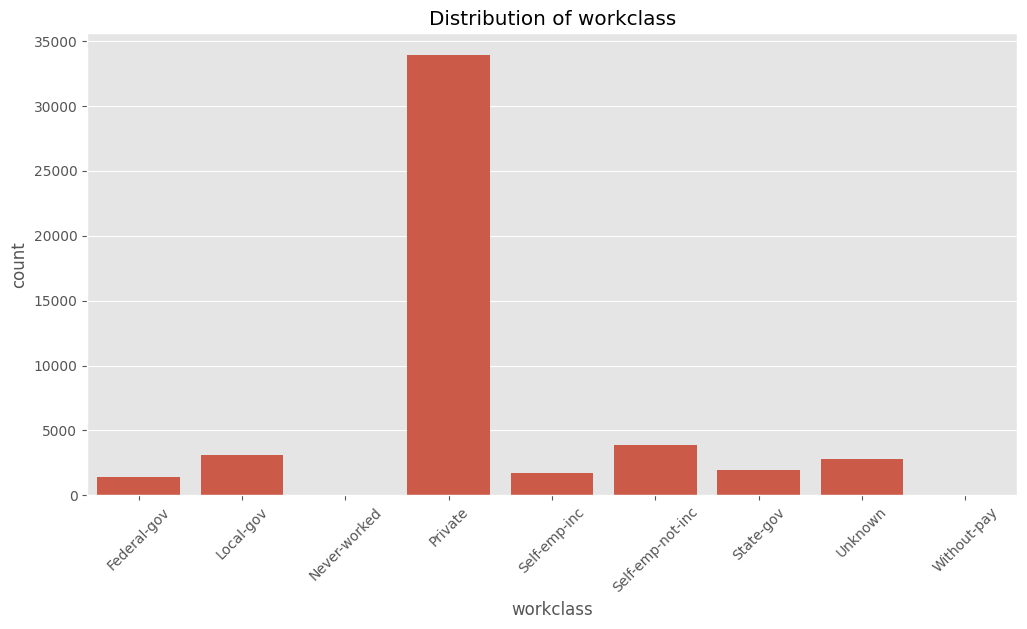

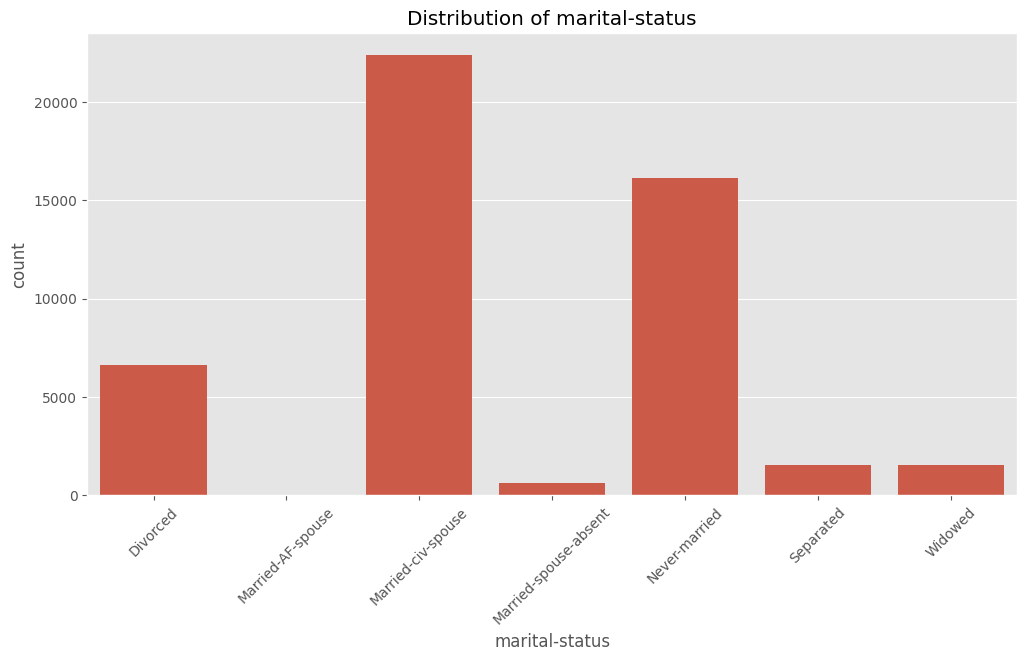

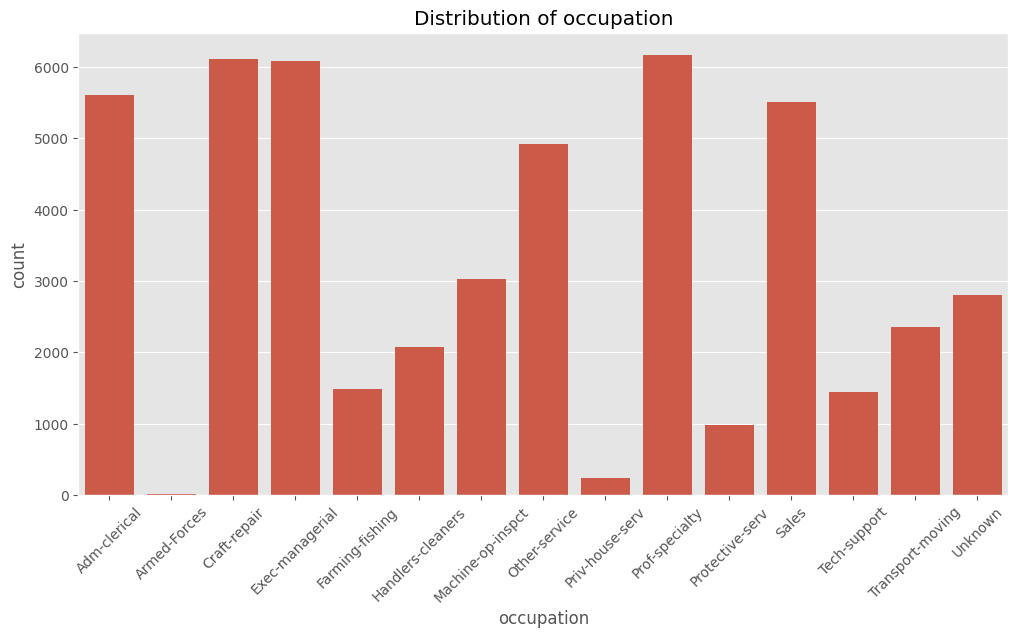

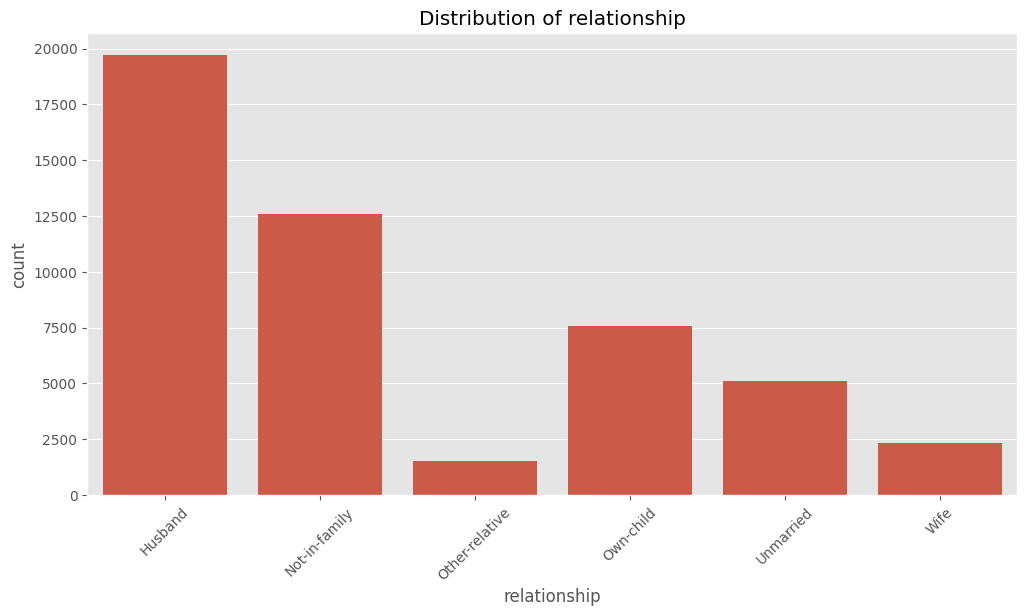

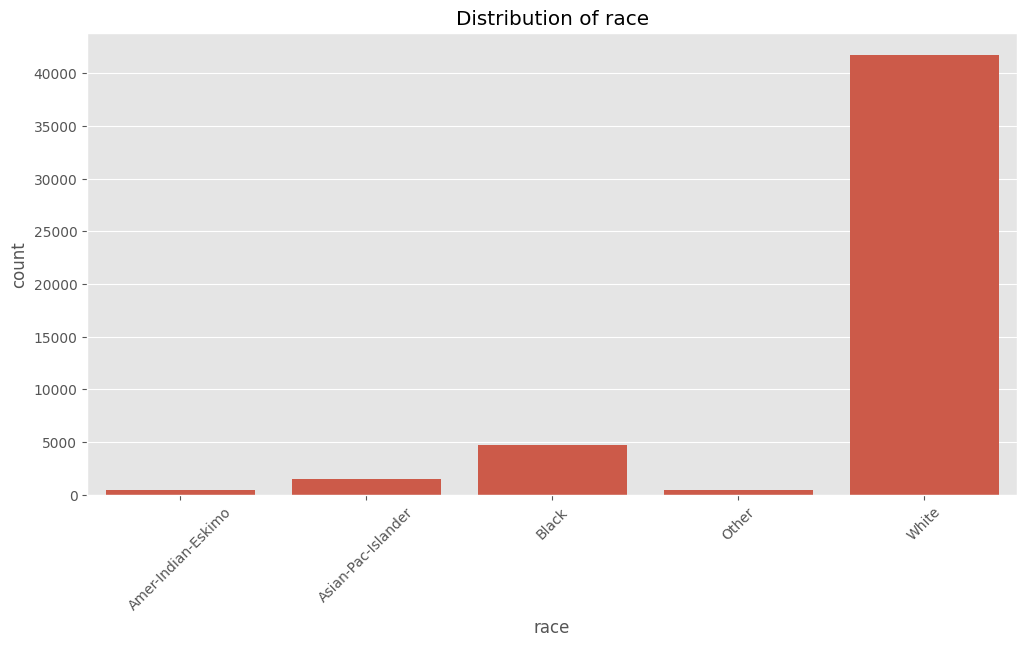

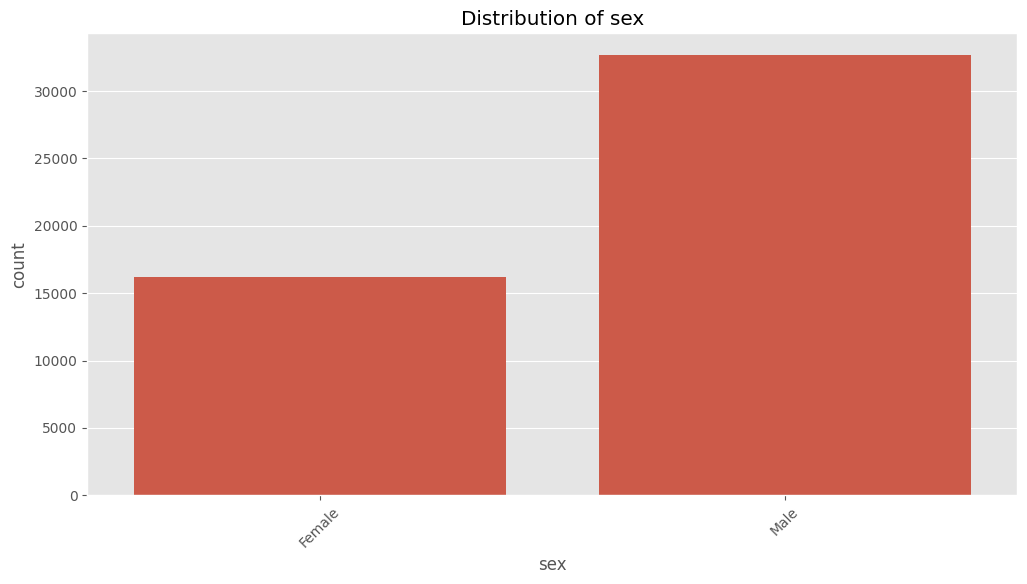

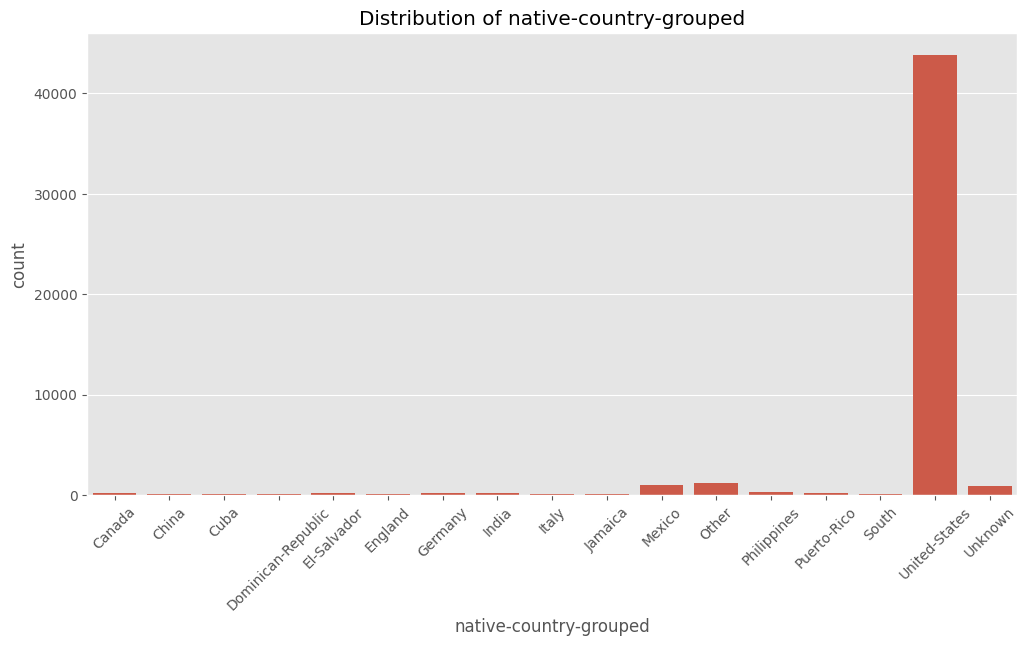

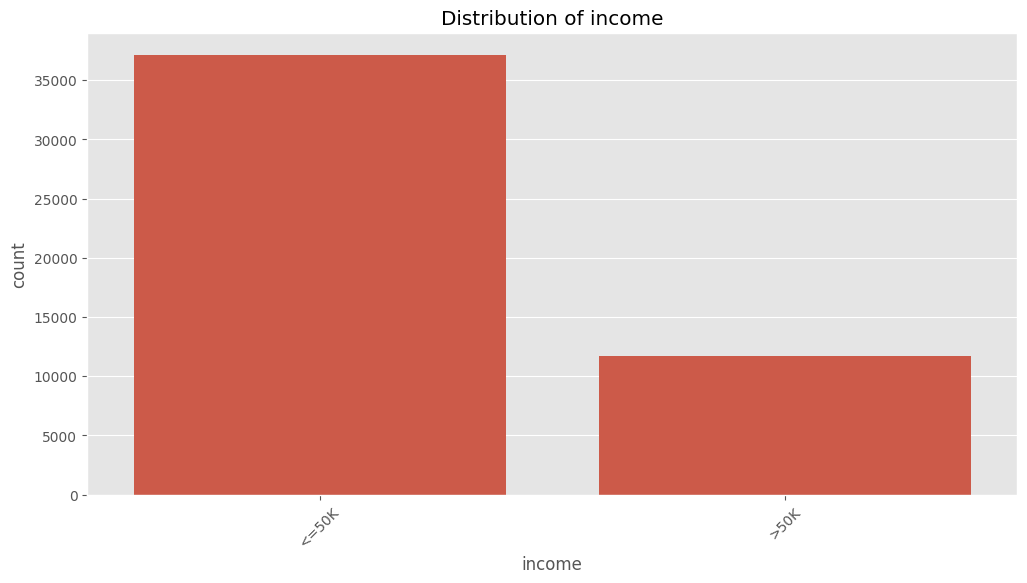

In [ ]:

# Plot the count of categorical variables
categorical_columns = ['workclass', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country-grouped', 'income']

for col in categorical_columns:
    plt.figure(figsize=(12,6))
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.show()

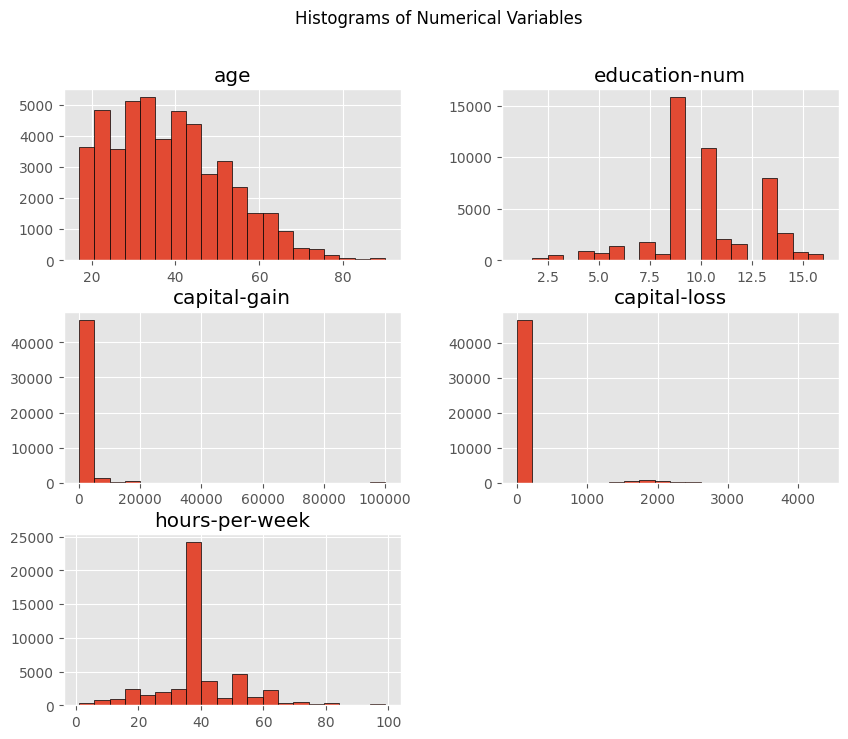

In [ ]:
# Plot histograms of numerical variables
numerical_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

df[numerical_columns].hist(figsize=(10,8), bins=20, edgecolor='black')
plt.suptitle("Histograms of Numerical Variables")
plt.show()

## Data Distribution Analysis

## `Age`
- **Distribution**: Right-skewed
- **Description**: Most individuals are in the 20 to 50 age range. The number of observations decreases significantly for those above 50, with very few individuals over 80.

## `Education-num`
- **Distribution**: Right-skewed
- **Description**: Peaks around the value of 9-10, indicating that most individuals in the dataset have a middle level of education.

## `Capital-gain`
- **Distribution**: Concentrated at 0
- **Description**: The majority of individuals report no capital gains, with only a few having significant capital gains. There are some outliers with capital gains exceeding 50,000.

## `Capital-loss`
- **Distribution**: Concentrated at 0
- **Description**: Most individuals report no capital loss, with a few having small losses and very few reporting larger amounts.

## `Hours-per-week`
- **Distribution**: Centred around 40 hours
- **Description**: Most individuals work a standard full-time schedule of 40 hours per week. There are fewer individuals working significantly fewer or more hours.


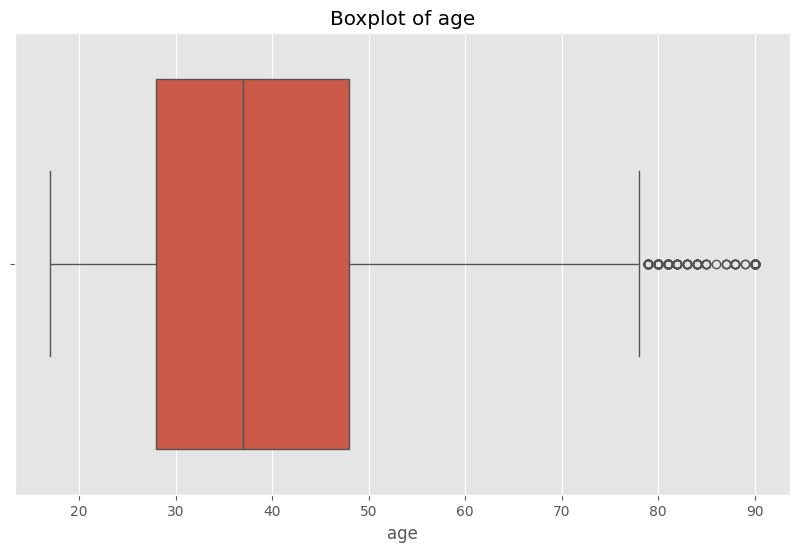

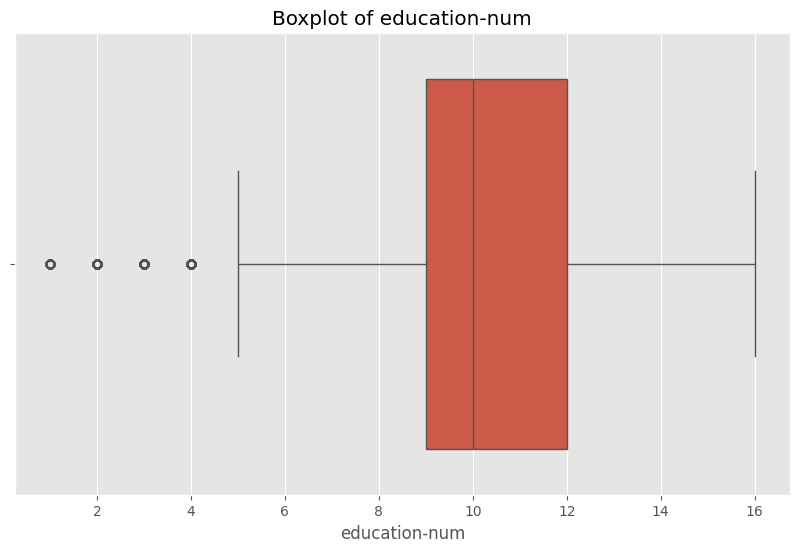

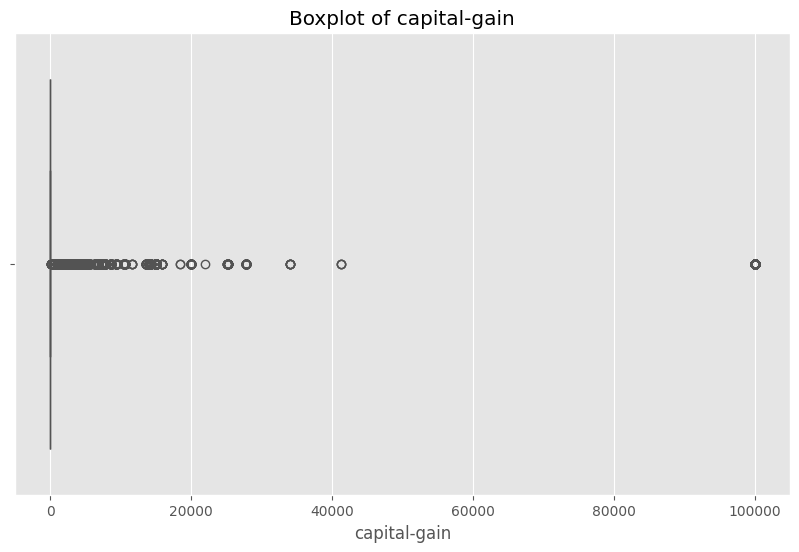

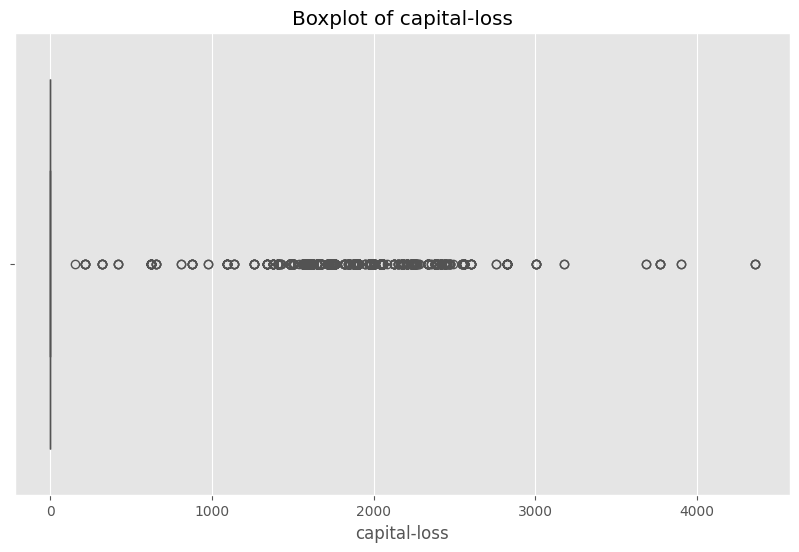

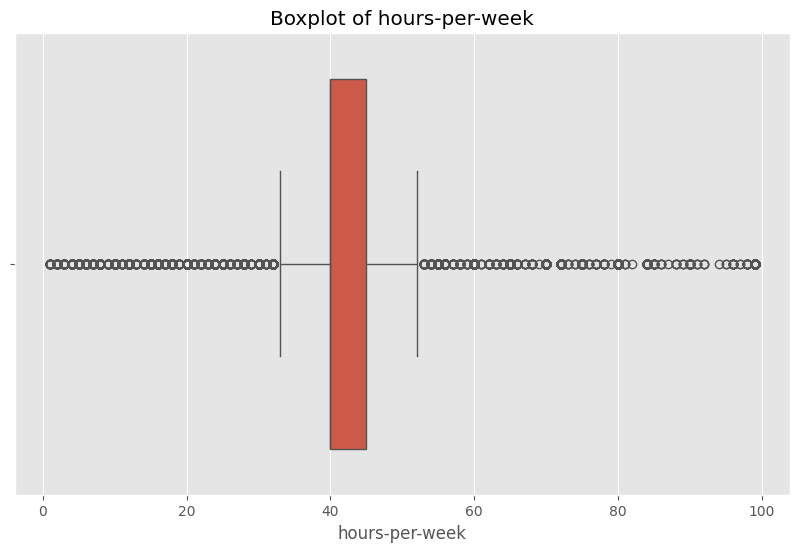

In [ ]:
# Plot boxplots to check for outliers
for col in numerical_columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


We can see from the boxplots above how skewed our dataset is, with many variables showing significant skewness and the presence of numerous outliers
.

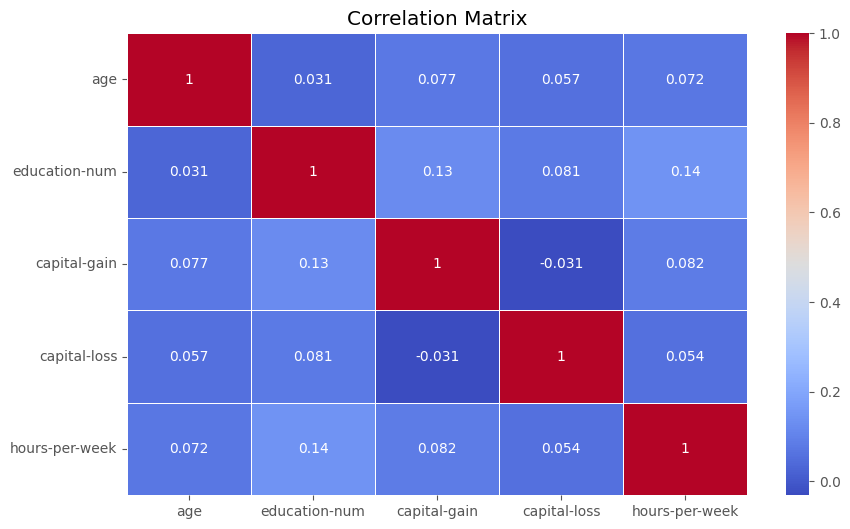

In [ ]:
# Correlation matrix for numerical variables
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Interpretation of the Correlation Matrix

The heatmap represents the correlation matrix between various numerical variables in the dataset, highlighting the strength and direction of linear relationships between pairs of variables.

#### Key Observations:

1. **Age**:
   - The correlation between **`age`** and other variables is weak. The strongest correlation (still very weak) is with **`capital-gain`** (0.077). This suggests that age has minimal influence on capital gains or other variables in this dataset.

2. **Education-num**:
   - **`Education-num`** (which represents the level of education) has the highest correlation with **`capital-gain`** (0.13) and **`hours-per-week`** (0.14). Although these correlations are weak, they suggest that more educated individuals may work more hours per week and potentially earn higher capital gains.

3. **Capital-gain** and **Capital-loss**:
   - There is a slight negative correlation between **`capital-gain`** and **`capital-loss`** (-0.031). This indicates that individuals who tend to gain more capital generally tend to lose less, although the correlation is very weak.

4. **Hours-per-week**:
   - **`Hours-per-week`** has a weak positive correlation with **`education-num`** (0.14) and **`capital-gain`** (0.082). This implies that individuals who work more hours tend to have slightly higher education levels and may earn more capital, though these relationships are not strong.

5. **Capital-loss**:
   - **`capital-loss`** shows a weak negative correlation with **`capital-gain`** (-0.031) but a weak positive correlation with **`education-num`** (0.081). This suggests that more educated individuals experience both capital gains and losses, though the relationships are weak.



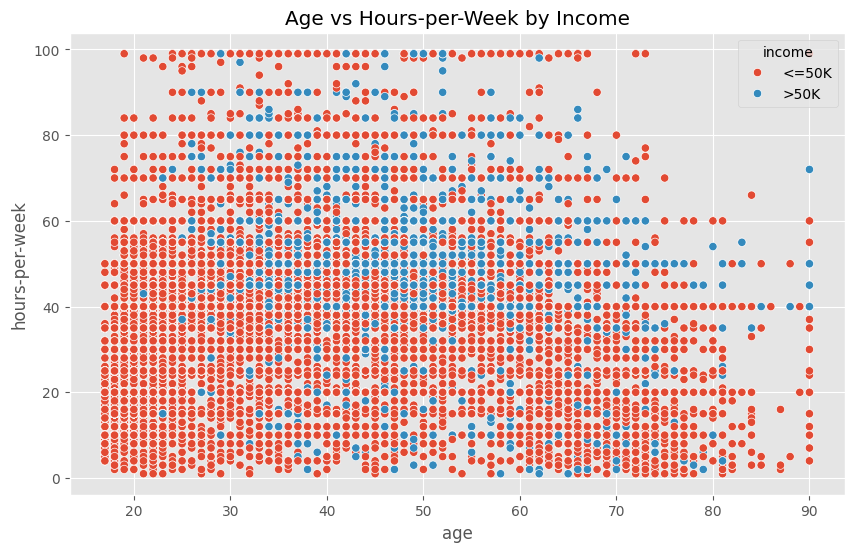

In [ ]:
# Scatter plot of age vs hours-per-week colored by income
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='age', y='hours-per-week', hue='income')
plt.title("Age vs Hours-per-Week by Income")
plt.show()

### Scatter Plot Analysis: Age vs. Hours-per-Week by Income

The scatter plot visualizes the relationship between age and hours worked per week, colored by income categories:
- **Red dots** represent individuals earning less than $50K per year.
- **Blue dots** represent individuals earning more than $50K per year.

### Observations:
- A significant cluster of red dots at around 40 hours per week across all ages indicates that a standard full-time job is prevalent among those earning under $50K.
- Blue dots, while generally distributed across the age and hours range, are notably more common in the higher hours-per-week categories, suggesting that higher earners often work longer hours.
- The density of both red and blue dots decreases with age after 60, which might indicate retirement or reduction in working hours.


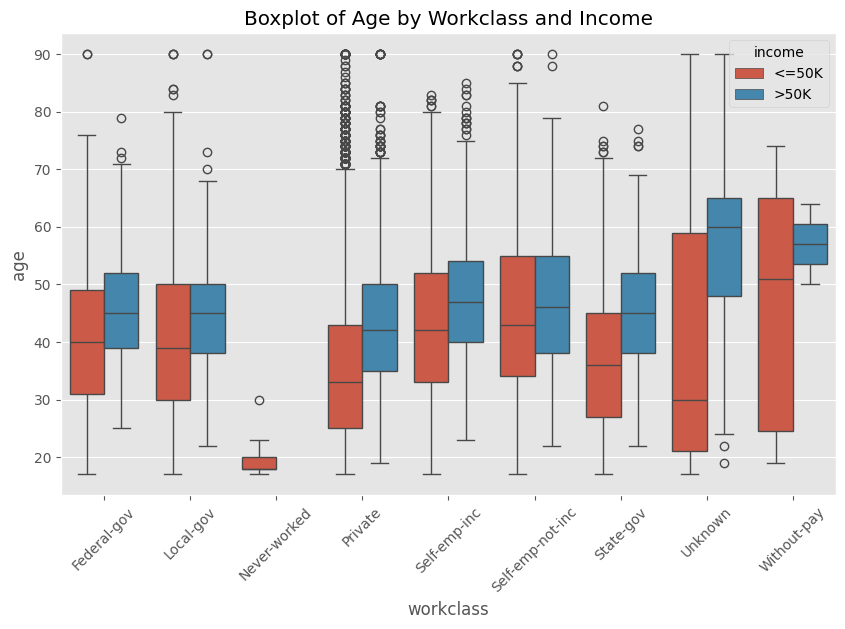

In [ ]:
# Boxplot of age by workclass
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='workclass', y='age', hue='income')
plt.xticks(rotation=45)
plt.title("Boxplot of Age by Workclass and Income")
plt.show()

### Boxplot Analysis: Age Distribution Across Workclass Categories and Income Levels

#### Key Observations:

1. **Age Distribution by Workclass**:
   - The median age for most workclasses falls between 40 and 50.
   - Employees in **State-gov** and **Federal-gov** categories tend to be slightly older than those in other workclasses.
   - Individuals in the **Never-worked** category are generally younger compared to others.

2. **Age Distribution by Income**:
   - Individuals earning more than **$50K** are generally older than those earning less than $50K.
   - The median age for individuals earning more than **$50K** is approximately 50, while for those earning less than $50K, the **median age** is closer to **40**.

3. **Interaction Between Workclass and Income**:
   - For both **Federal-gov** and **State-gov** employees, the age distribution for those earning more than **$50K** is shifted to the right (older) compared to other workclasses.
   - **Private** employees earning more than $50K show a wider age distribution compared to those earning less.
   - Employees categorized as **Self-emp-inc** who earn more than **$50K** tend to be older compared to those earning less than **$50K**.


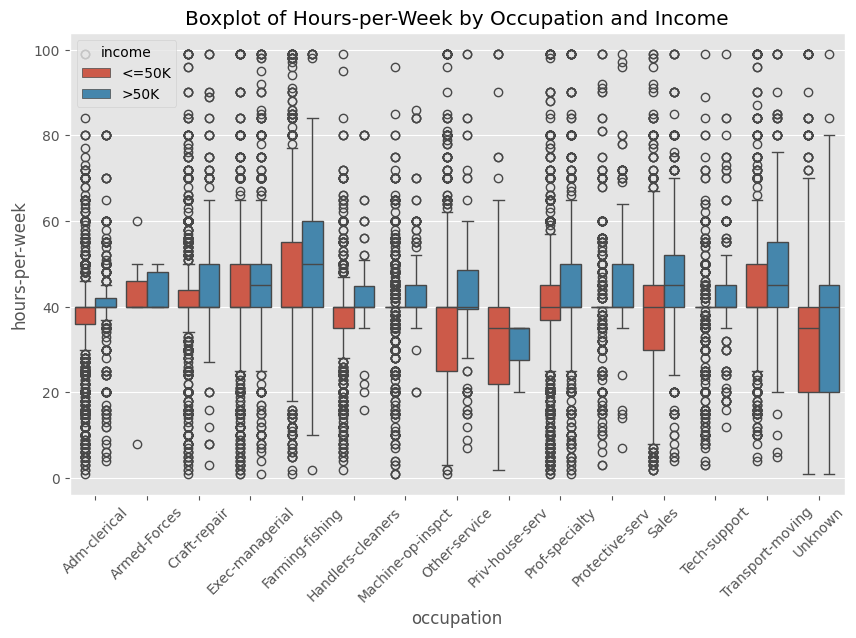

In [ ]:
# Boxplot of hours-per-week by occupation
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='occupation', y='hours-per-week', hue='income')
plt.xticks(rotation=45)
plt.title("Boxplot of Hours-per-Week by Occupation and Income")
plt.show()

### Hours-per-Week Distribution by Occupation and Income Levels

#### Key Insights:

1. **Hours-per-Week Distribution by Occupation**:
   - Occupations such as "Exec-managerial" and "Prof-specialty" have the highest median hours-per-week, indicating that individuals in these roles tend to work longer hours.
   - In contrast, "Armed-Forces" and "Transport-moving" occupations have the lowest median hours-per-week.
   - Many occupations exhibit a wide range of hours-per-week, suggesting significant variability in work hours across different jobs.

2. **Hours-per-Week Distribution by Income**:
   - Individuals earning more than $50K generally work more hours per week than those earning less than $50K.
   - The median hours-per-week for higher-income individuals is approximately 50-60 hours, compared to around 40 hours for those earning less than $50K.

3. **Interaction Between Occupation and Income**:
   - Employees in "Exec-managerial" and "Prof-specialty" positions earning more than $50K work significantly longer hours than their lower-income counterparts in the same occupations.
   - "Armed-Forces" and "Transport-moving" employees show consistent work hours regardless of their income level, with less variation between income groups.
   - Other occupations exhibit varying degrees of overlap between income groups in terms of hours-per-week, indicating that income is not always strongly correlated with work hours across all job categories.


income               <=50K      >50K
workclass                           
Federal-gov       0.608240  0.391760
Local-gov         0.704401  0.295599
Never-worked      1.000000  0.000000
Private           0.782133  0.217867
Self-emp-inc      0.446608  0.553392
Self-emp-not-inc  0.721129  0.278871
State-gov         0.732458  0.267542
Unknown           0.905323  0.094677
Without-pay       0.904762  0.095238


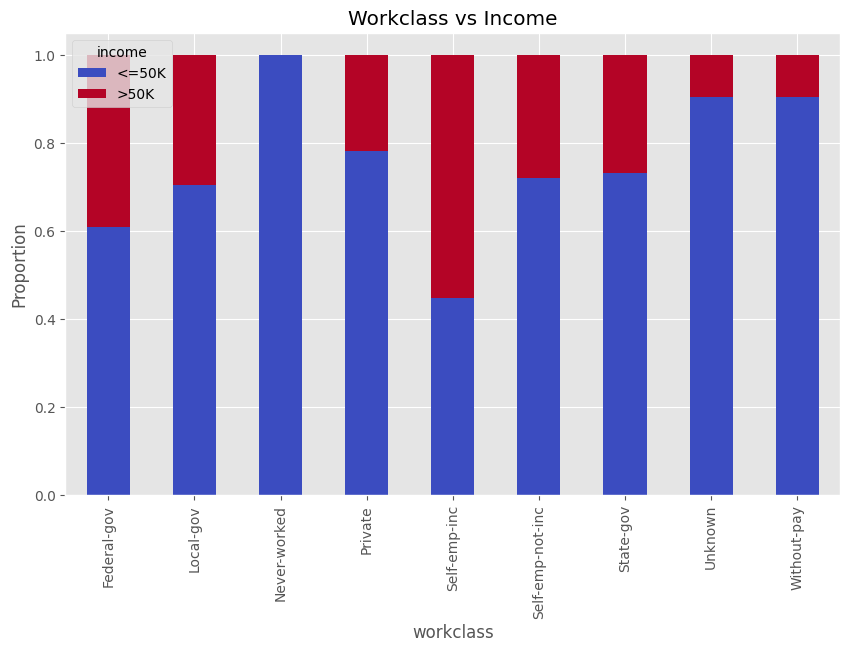

In [ ]:
# Cross-tabulation of workclass and income
workclass_income = pd.crosstab(df['workclass'], df['income'], normalize='index')
print(workclass_income)

# Plot the cross-tabulation
workclass_income.plot(kind='bar', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.title('Workclass vs Income')
plt.ylabel('Proportion')
plt.show()

### Key Observations on Income Distribution by Workclass

#### 1. **Income Distribution by Workclass**:
   - **Federal-gov** and **Local-gov** employees show a higher proportion of individuals earning more than $50K compared to other workclasses. This indicates that government jobs, particularly at the federal and local levels, tend to offer higher pay.
   - **Private** sector employees have a more balanced income distribution, with a relatively equal proportion of individuals earning both below and above the $50K threshold.
   - Individuals classified under **Never-worked** and **Without-pay** predominantly earn less than $50K, reflecting the absence or lack of formal employment in these categories.

#### 2. **Income Differences Across Workclasses**:
   - Significant disparities exist in income distribution across different workclasses.
   - Workclasses such as **Federal-gov** and **Local-gov** have a much larger share of individuals earning more than $50K, emphasizing the role of government jobs in providing higher income opportunities.
   - Other workclasses, particularly **Private** and **Self-employed**, exhibit more varied income distributions, indicating that factors such as job roles, industries, and levels of experience might contribute to income diversity within these groups.

# Data Preprocessing

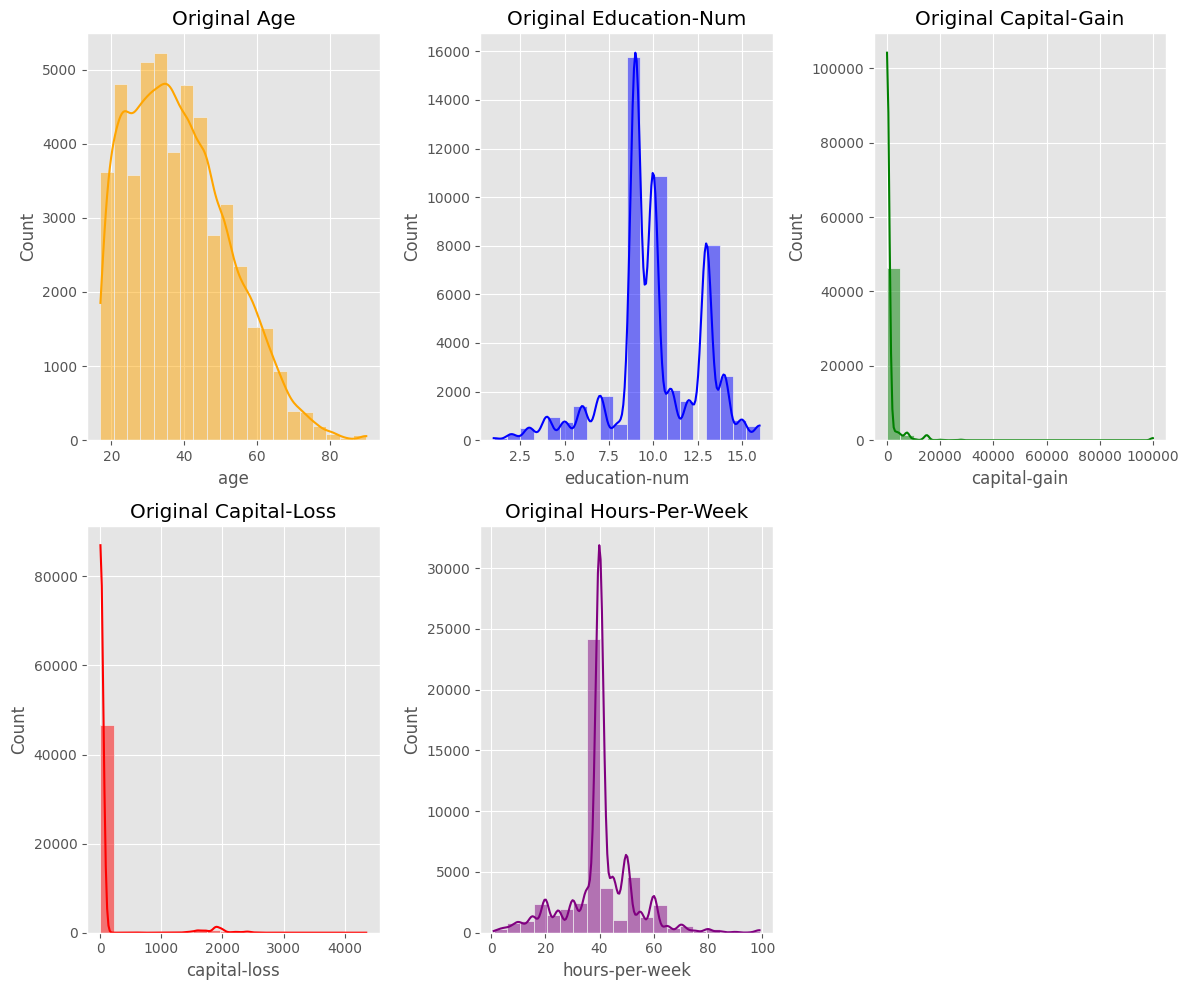

In [ ]:
# Visualize original data distributions
plt.figure(figsize=(12, 10))

plt.subplot(2, 3, 1)
sns.histplot(df['age'], bins=20, kde=True, color='orange')
plt.title('Original Age')

plt.subplot(2, 3, 2)
sns.histplot(df['education-num'], bins=20, kde=True, color='blue')
plt.title('Original Education-Num')

plt.subplot(2, 3, 3)
sns.histplot(df['capital-gain'], bins=20, kde=True, color='green')
plt.title('Original Capital-Gain')

plt.subplot(2, 3, 4)
sns.histplot(df['capital-loss'], bins=20, kde=True, color='red')
plt.title('Original Capital-Loss')

plt.subplot(2, 3, 5)
sns.histplot(df['hours-per-week'], bins=20, kde=True, color='purple')
plt.title('Original Hours-Per-Week')

plt.tight_layout()
plt.show()

In [ ]:
# Checking Data Distributions

# Use skewness metric to check improvement after transformation
print('Original Skewness of Age:', df['age'].skew())
print('Original Skewness of Education-num:', pd.Series(df['education-num']).skew())
print('Original Skewness of Capital-gain:', df['capital-gain'].skew())
print('Original Skewness of Capital-loss:', df['capital-loss'].skew())
print('Original Skewness of Hours-per-week:', df['hours-per-week'].skew())

Original Skewness of Age: 0.5575803166133182
Original Skewness of Education-num: -0.3165248566607419
Original Skewness of Capital-gain: 11.894658996587948
Original Skewness of Capital-loss: 4.569808857738483
Original Skewness of Hours-per-week: 0.23874965720275756


In [ ]:
# Apply Transformations

# Log transformation for capital-gain and capital-loss
df['capital-gain'] = np.log1p(df['capital-gain'])  # log1p = log(x + 1) to handle zeros
df['capital-loss'] = np.log1p(df['capital-loss'])

# Square root transformation for age and hours-per-week
df['age'] = np.sqrt(df['age'])
df['hours-per-week'] = np.sqrt(df['hours-per-week'])

# Box-Cox transformation for education-num (this requires positive values)
pt = PowerTransformer(method='box-cox')
df['education-num'] = pt.fit_transform(df[['education-num']])

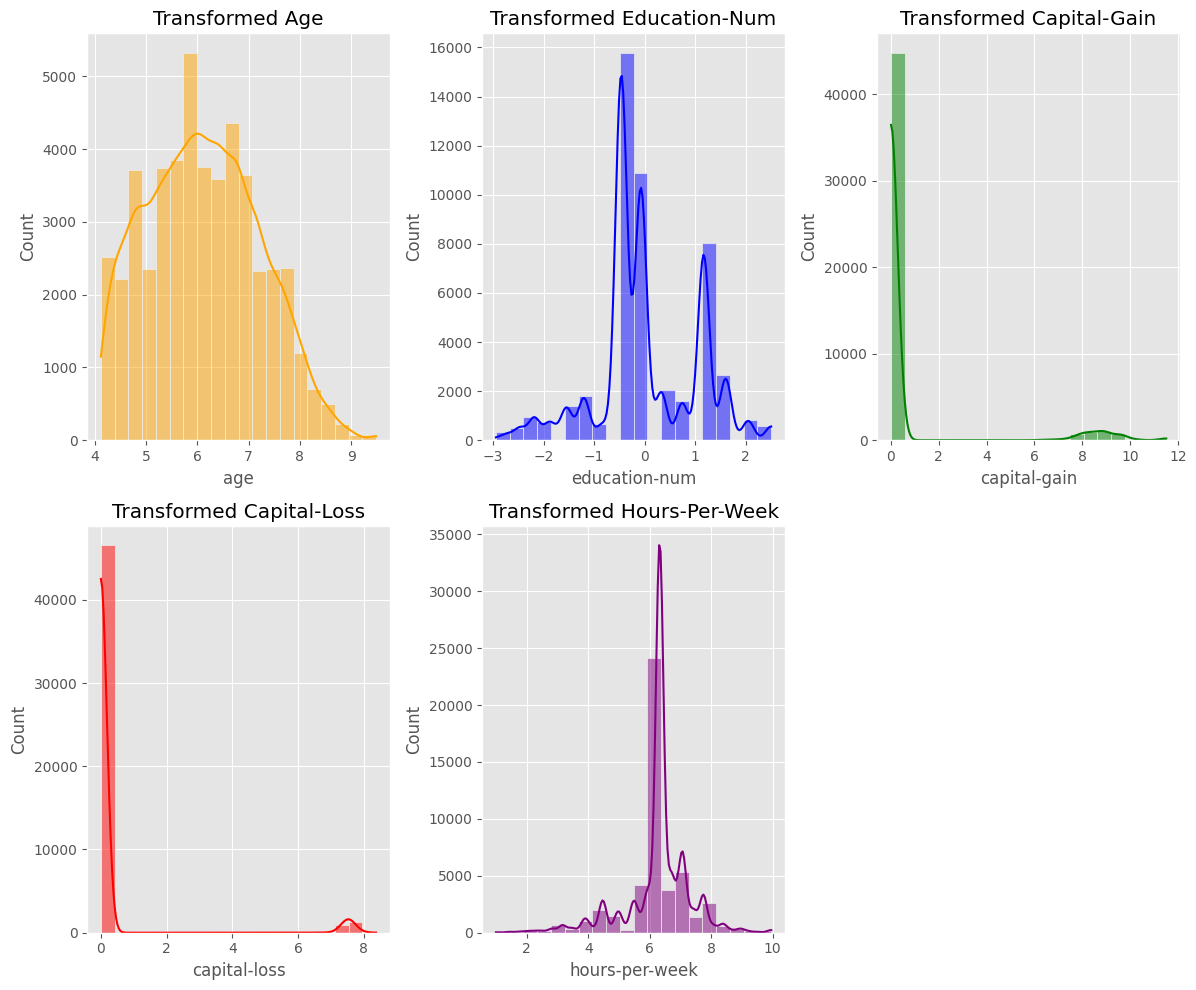

In [ ]:
# Visualize Transformed Data

plt.figure(figsize=(12, 10))

plt.subplot(2, 3, 1)
sns.histplot(df['age'], bins=20, kde=True, color='orange')
plt.title('Transformed Age')

plt.subplot(2, 3, 2)
sns.histplot(df['education-num'], bins=20, kde=True, color='blue')
plt.title('Transformed Education-Num')

plt.subplot(2, 3, 3)
sns.histplot(df['capital-gain'], bins=20, kde=True, color='green')
plt.title('Transformed Capital-Gain')

plt.subplot(2, 3, 4)
sns.histplot(df['capital-loss'], bins=20, kde=True, color='red')
plt.title('Transformed Capital-Loss')

plt.subplot(2, 3, 5)
sns.histplot(df['hours-per-week'], bins=20, kde=True, color='purple')
plt.title('Transformed Hours-Per-Week')

plt.tight_layout()
plt.show()

In [ ]:
# Checking Data Distributions

# Use skewness metric to check improvement after transformation
print('Transformed Skewness of Age:', df['age'].skew())
print('Transformed Skewness of Education-num:', pd.Series(df['education-num']).skew())
print('Transformed Skewness of Capital-gain:', df['capital-gain'].skew())
print('Transformed Skewness of Capital-loss:', df['capital-loss'].skew())
print('Transformed Skewness of Hours-per-week:', df['hours-per-week'].skew())

Transformed Skewness of Age: 0.2041118105446602
Transformed Skewness of Education-num: 0.018445901693310715
Transformed Skewness of Capital-gain: 3.113630383874109
Transformed Skewness of Capital-loss: 4.302959523998299
Transformed Skewness of Hours-per-week: -0.9809657170852346


## Feature Distribution Analysis

### `age`

- **Original Skewness**: 0.558
- **Transformed Skewness**: 0.204
- **Distribution**: The transformed distribution is more symmetrical than the original distribution, with a clear peak around 5-6.
- **Skewness**: The skewness has been significantly reduced, indicating that the transformation has been effective in addressing the right-skewness of the original data.

### `education-num`

- **Original Skewness**: -0.317
- **Transformed Skewness**: 0.018
- **Distribution**: The transformed distribution is still relatively symmetric, but with a slightly wider spread compared to the original distribution.
- **Normalization**: The transformation has helped to normalize the data, making it easier to interpret the distribution.

### `capital-gain`

- **Original Skewness**: 11.895
- **Transformed Skewness**: 3.114
- **Distribution**: The transformed distribution is more symmetrical than the original distribution, with a clear peak around 0.2-0.3.
- **Skewness**: The skewness has been significantly reduced, although it's still slightly right-skewed.
- **Range**: The transformation has helped to compress the range of values, making the distribution more manageable.

### `capital-loss`

- **Original Skewness**: 4.570
- **Transformed Skewness**: 4.303
- **Distribution**: The transformed distribution is more symmetrical than the original distribution, with a clear peak around 0.2-0.3.
- **Skewness**: The skewness has been significantly reduced, although it's still slightly right-skewed.
- **Range**: The transformation has helped to compress the range of values, making the distribution more manageable.

### `hours-per-week`

- **Original Skewness**: 0.239
- **Transformed Skewness**: -0.981
- **Distribution**: The transformed distribution is more symmetrical than the original distribution, with a clear peak around 5-6.
- **Skewness**: The skewness has been significantly reduced, although it's still slightly left-skewed.
- **Range**: The transformation has helped to compress the range of values, making the distribution more manageable.


# Feature Engineering

In [ ]:
# Create new feature interaction
# Interaction between age and capital gain.
df['age*capital-gain'] = df['age'] * df['capital-gain']

# Polynomial features
# Square  of age
df['age_squared'] = df['age'] ** 2

# Square of capital-gain
df['capital-gain_squared'] = df['capital-gain'] ** 2

# Square of capital-loss
df['capital-loss_squared'] = df['capital-loss'] ** 2

# Square of hours-per-week
df['hours-per-week_squared'] = df['hours-per-week'] ** 2

# Square of education-num
df['education-num_squared'] = df['education-num'] ** 2


# Define bins and labels based on the log-transformed age range
age_bins = [4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 9.5]  # Adjusted for log values between 4.12 and 9.49
age_labels = ['4-5', '5-6', '6-7', '7-8', '8-9', '9-9.5']

# Apply binning for log-transformed age
df['age_bins'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Define bins and labels for capital-gain
capital_gain_bins = [0, 5000, 10000, 20000, 50000, 100000]  # Adjusted bins for 0 to 99999 range
capital_gain_labels = ['0-5k', '5k-10k', '10k-20k', '20k-50k', '50k-100k']

# Define bins and labels for capital-loss
capital_loss_bins = [0, 1000, 2000, 3000, 4000, 5000]  # Adjusted bins for 0 to 4356 range
capital_loss_labels = ['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k-5k']

# Apply binning for capital-gain
df['capital-gain_bins'] = pd.cut(df['capital-gain'], bins=capital_gain_bins, labels=capital_gain_labels, include_lowest=True)

# Apply binning for capital-loss
df['capital-loss_bins'] = pd.cut(df['capital-loss'], bins=capital_loss_bins, labels=capital_loss_labels, include_lowest=True)

# Create interaction between 'hours-per-week' and 'occupation'
# Categorical 'occupation' is encoded to numeric using .cat.codes
df['hours-per-week*occupation'] = df['hours-per-week'] * df['occupation'].cat.codes

# Interaction between 'capital-gain' and 'capital-loss' to represent net capital
df['net_capital'] = df['capital-gain'] - df['capital-loss']

# Create a feature representing the ratio of 'capital-gain' to 'hours-per-week'
df['capital_gain_per_hour'] = df['capital-gain'] / df['hours-per-week']

# Interaction between 'age' and 'hours-per-week
df['age*hours-per-week'] = df['age'] * df['hours-per-week']

# Interaction between 'capital-gain' and 'capital-loss'
df['capital-gain*capital-loss'] = df['capital-gain'] * df['capital-loss']

# Interaction between 'education-num' and 'hours-per-week'
df['education-num*hours-per-week'] = df['education-num'] * df['hours-per-week']

# Interaction between 'age' and 'education-num'
df['age*education-num'] = df['age'] * df['education-num']

# Square root transformation of 'age'
df['age_sqrt'] = np.sqrt(df['age'])

# Logarithmic transformation of 'capital-gain'
df['log_capital-gain'] = np.log1p(df['capital-gain'])

# Ratio of 'education-num' to 'age'. This captures how educational attainment compares to age.
df['education_age_ratio'] = df['education-num'] / df['age']

# Interaction between 'hours-per-week' and the encoded 'capital-gain_bins'
df['hours-per-week*capital-gain_bins'] = df['hours-per-week'] * df['capital-gain_bins'].cat.codes

# Interaction between age and education-num
df['age*education-num'] = df['age'] * df['education-num']

# Interaction between hours-per-week and education-num
df['hours-per-week*education-num'] = df['hours-per-week'] * df['education-num']

# Interaction between capital-gain and hours-per-week
df['capital-gain*hours-per-week'] = df['capital-gain'] * df['hours-per-week']

# Interaction between age and capital-loss
df['age*capital-loss'] = df['age'] * df['capital-loss']

# Log of hours-per-week
df['log_hours-per-week'] = np.log1p(df['hours-per-week'])

# Ratio of capital-gain to hours-per-week
df['capital_gain_hours_ratio'] = df['capital-gain'] / df['hours-per-week']

# Ratio of education-num to capital-gain
df['education_capital_ratio'] = df['education-num'] / (df['capital-gain'] + 1)

# Ratio of capital-loss to age
df['capital_loss_age_ratio'] = df['capital-loss'] / (df['age'] + 1)


# Cube of age
df['age_cubed'] = df['age'] ** 3

# Normalize age
df['age_normalized'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())

# Normalize hours-per-week
df['hours-per-week_normalized'] = (df['hours-per-week'] - df['hours-per-week'].min()) / (df['hours-per-week'].max() - df['hours-per-week'].min())

# Interaction between education-num and occupation (encoded as category codes)
df['education-num*occupation'] = df['education-num'] * df['occupation'].cat.codes

# Interaction between age and marital-status (encoded as category codes)
df['age*marital-status'] = df['age'] * df['marital-status'].cat.codes

In [ ]:
df.columns

Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income', 'native-country-grouped',
       'age*capital-gain', 'age_squared', 'capital-gain_squared',
       'capital-loss_squared', 'hours-per-week_squared',
       'education-num_squared', 'age_bins', 'capital-gain_bins',
       'capital-loss_bins', 'hours-per-week*occupation', 'net_capital',
       'capital_gain_per_hour', 'age*hours-per-week',
       'capital-gain*capital-loss', 'education-num*hours-per-week',
       'age*education-num', 'age_sqrt', 'log_capital-gain',
       'education_age_ratio', 'hours-per-week*capital-gain_bins',
       'hours-per-week*education-num', 'capital-gain*hours-per-week',
       'age*capital-loss', 'log_hours-per-week', 'capital_gain_hours_ratio',
       'education_capital_ratio', 'capital_loss_age_ratio', 'age_cubed',
       'age_normalized', 'hours-per-week_normalized',
       'edu

In [ ]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

,0


In [ ]:
df.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,...,age*capital-loss,log_hours-per-week,capital_gain_hours_ratio,education_capital_ratio,capital_loss_age_ratio,age_cubed,age_normalized,hours-per-week_normalized,education-num*occupation,age*marital-status
0,6.244998,State-gov,1.167490,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0.0,...,0.0,1.991232,1.215071,0.134429,0.0,243.554922,0.395600,0.594931,0.000000,24.979992
1,7.071068,Self-emp-not-inc,1.167490,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,...,0.0,1.527262,0.000000,1.167490,0.0,353.553391,0.549611,0.291127,3.502469,14.142136
2,6.164414,Private,-0.463893,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,...,0.0,1.991232,0.000000,-0.463893,0.0,234.247732,0.380576,0.594931,-2.319465,0.000000
3,7.280110,Private,-1.202394,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,...,0.0,1.991232,0.000000,-1.202394,0.0,385.845824,0.588584,0.594931,-6.011969,14.560220
4,5.291503,Private,1.167490,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,...,0.0,1.991232,0.000000,1.167490,0.0,148.162073,0.217833,0.594931,10.507408,10.583005


In [ ]:
# Initialize label encoder and standard scaler
label_encoder = LabelEncoder()
scaler = StandardScaler()

# List of columns to label encode
label_encode_cols = ['income', 'age_bins', 'capital-gain_bins', 'capital-loss_bins', 'hours-per-week*occupation']

# Apply label encoding
for col in label_encode_cols:
    df[col] = label_encoder.fit_transform(df[col])

# List of columns to one-hot encode
one_hot_encode_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country-grouped']

# Apply one-hot encoding
df = pd.get_dummies(df, columns=one_hot_encode_cols, drop_first=True)

# List of continuous numerical columns
numerical_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week',
                  'age*capital-gain', 'age_squared', 'capital-gain_squared', 'capital-loss_squared',
                  'net_capital', 'capital_gain_per_hour', 'age*hours-per-week', 'capital-gain*capital-loss',
                  'education-num*hours-per-week', 'age*education-num', 'age_sqrt', 'log_capital-gain',
                  'education_age_ratio', 'hours-per-week*capital-gain_bins', 'hours-per-week*education-num',
                  'capital-gain*hours-per-week', 'age*capital-loss', 'log_hours-per-week',
                  'capital_gain_hours_ratio', 'education_capital_ratio', 'capital_loss_age_ratio',
                  'age_cubed', 'age_normalized', 'hours-per-week_normalized', 'education-num*occupation',
                  'age*marital-status']

# Apply scaling to numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [ ]:
df.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,income,age*capital-gain,age_squared,capital-gain_squared,capital-loss_squared,...,native-country-grouped_India,native-country-grouped_Italy,native-country-grouped_Jamaica,native-country-grouped_Mexico,native-country-grouped_Other,native-country-grouped_Philippines,native-country-grouped_Puerto-Rico,native-country-grouped_South,native-country-grouped_United-States,native-country-grouped_Unknown
0,0.114868,1.167490,2.844559,-0.221264,0.052243,0,2.642738,0.025996,2.350537,-0.220953,...,False,False,False,False,False,False,False,False,True,False
1,0.869503,1.167490,-0.297918,-0.221264,-2.519162,0,-0.293544,0.828308,-0.291263,-0.220953,...,False,False,False,False,False,False,False,False,True,False
2,0.041252,-0.463893,-0.297918,-0.221264,0.052243,0,-0.293544,-0.046942,-0.291263,-0.220953,...,False,False,False,False,False,False,False,False,True,False
3,1.060468,-1.202394,-0.297918,-0.221264,0.052243,0,-0.293544,1.047121,-0.291263,-0.220953,...,False,False,False,False,False,False,False,False,True,False
4,-0.756173,1.167490,-0.297918,-0.221264,0.052243,0,-0.293544,-0.776316,-0.291263,-0.220953,...,False,False,False,False,False,False,False,False,False,False


# Model Development

In [ ]:
# Separate into feature and target variables
X = df.drop('income', axis=1)  # Features
y = df['income']  # Target

In [ ]:
# Split our dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

## XBClassifier Model

Optuna was used for hyperparameter optimization for the xgboost model

In [ ]:
'''
# Define the objective function for Optuna
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0)
    }

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    f1_scores = []

    # Perform Stratified K-Fold cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]

        # Access y_train using iloc to ensure alignment with skf.split indices
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train the model with the current fold's training data
        model = XGBClassifier(**param)
        model.fit(X_fold_train, y_fold_train)

        # Make predictions on the validation fold
        preds = model.predict(X_fold_val)

        # Calculate F1 score for the current fold
        f1 = f1_score(y_fold_val, preds)
        f1_scores.append(f1)

    # Return the average F1 score across all folds
    return sum(f1_scores) / len(f1_scores)

# Create an Optuna study to maximize the F1 score
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print('Best trial:', study.best_trial.params)

'''

"\n# Define the objective function for Optuna\ndef objective(trial):\n    param = {\n        'verbosity': 0,\n        'objective': 'binary:logistic',\n        'booster': 'gbtree',\n        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),\n        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),\n        'max_depth': trial.suggest_int('max_depth', 3, 9),\n        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),\n        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),\n        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),\n        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),\n        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),\n        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),\n        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0)\n    }\n\n    # Initialize StratifiedKFold\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\n    f1_scores =

I will be using the best parameter gotten from Optuna optimization here, because of the high cost of running it over and over again.

In [ ]:
# Define the best parameters from Optuna
best_params_xgb = {
    'lambda': 7.252180579117766e-05,
    'alpha': 0.0024556246296108045,
    'max_depth': 4,
    'eta': 1.0661166450847897e-06,
    'gamma': 2.275736791950776e-08,
    'subsample': 0.5097901298709799,
    'colsample_bytree': 0.6967125619908884,
    'min_child_weight': 7,
    'n_estimators': 598,
    'learning_rate': 0.06035658071128903
}

# Initialize the XGBClassifier with the best hyperparameters
best_xgb_model = XGBClassifier(
    **best_params_xgb,
    objective='binary:logistic',  # Binary classification
    booster='gbtree',
    verbosity=0,
    random_state=42
)

# Train the model on the entire training set
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm_xgb = confusion_matrix(y_test, y_pred)
# Print evaluation results
print(f"Test Accuracy for Xgboost: {accuracy}")
print(f"F1 Score for Xgboost: {f1}")
print(f"Classification Report for Xgboost:\n{report}")
print(f"Confusion Matrix for Xgboost:\n{cm_xgb}")

Test Accuracy for Xgboost: 0.8719033644987375
F1 Score for Xgboost: 0.7108303805268835
Classification Report for Xgboost:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11169
           1       0.77      0.66      0.71      3484

    accuracy                           0.87     14653
   macro avg       0.83      0.80      0.81     14653
weighted avg       0.87      0.87      0.87     14653

Confusion Matrix for Xgboost:
[[10469   700]
 [ 1177  2307]]


### XGBoost Model Classification Report:

#### Class 0 (<=50K):
- **Precision**: 0.90  
  *90% of individuals predicted as <=50K are correctly classified.*
- **Recall**: 0.94  
  *94% of actual <=50K individuals are correctly classified.*
- **F1-Score**: 0.92  
  *A high F1-Score shows a strong balance between precision and recall.*

#### Class 1 (>50K):
- **Precision**: 0.77  
  *77% of individuals predicted as >50K are correctly classified.*
- **Recall**: 0.66  
  *66% of actual >50K individuals are correctly classified.*
- **F1-Score**: 0.71  
  *A lower F1-Score indicates room for improvement, especially in recall.*

#### Overall Metrics:
- **Accuracy**: 87.19%  
  *The model correctly classified 87.19% of the total instances.*
  
- **Macro Average**:
  - **Precision**: 0.83  
  - **Recall**: 0.80  
  - **F1-Score**: 0.81  
  *The macro average takes into account the performance on both classes equally, showing a slight dip in recall for class 1.*

- **Weighted Average**:
  - **Precision**: 0.87  
  - **Recall**: 0.87  
  - **F1-Score**: 0.87  
  *The weighted average accounts for class imbalance, indicating the model is overall performing well.

#### Class Imbalance:
- **Class Distribution**:
  - Class 0 (<=50K): 37,155 instances
  - Class 1 (>50K): 11,687 instances
  *The class imbalance affects the model's performance on class 1, leading to a lower recall and F1-Score for >50K individuals.

#### XGBoost Confusion Matrix Interpretation


- **True Positives (TP)**: 2307  
  The model correctly predicted 2307 instances of Class 1 (positive class, >50K income).

- **True Negatives (TN)**: 10469  
  The model correctly predicted 10469 instances of Class 0 (negative class, <=50K income).

- **False Positives (FP)**: 700  
  The model incorrectly predicted 700 instances as Class 1 when they were actually Class 0.

- **False Negatives (FN)**: 1177  
  The model incorrectly predicted 1177 instances as Class 0 when they were actually Class 1.

### Performance Insights

- The model performs well in identifying Class 0 (low-income individuals), with relatively few misclassifications (700).
- The model has improved its performance with Class 1 (higher-income individuals) compared to the Random Forest model, with fewer false negatives (1177) and more accurate predictions (2307).


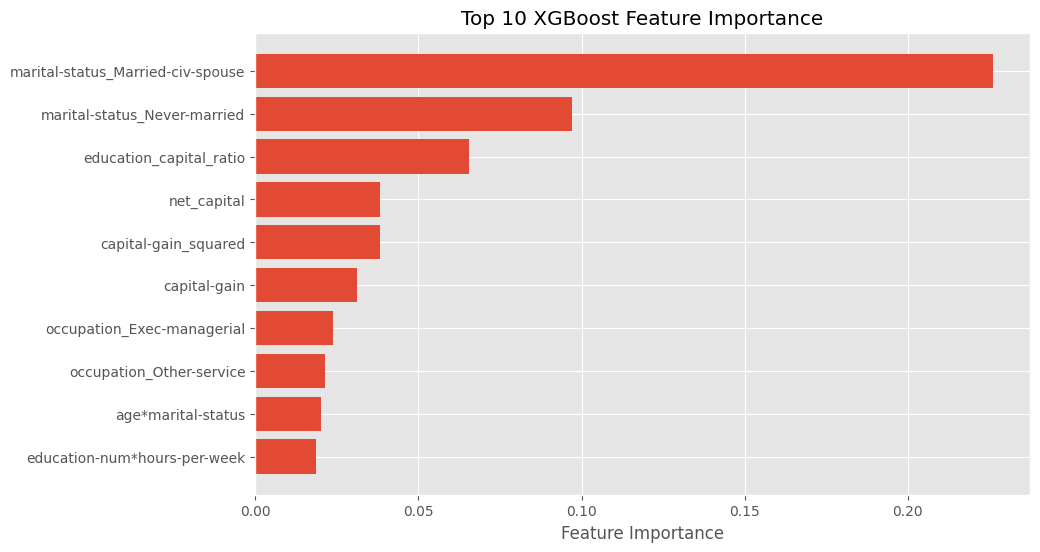

In [ ]:
# Get feature importance from the trained XGBoost model
xgb_feature_importances = best_xgb_model.feature_importances_

# Create a DataFrame and sort by importance
xgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_xgb_features = xgb_feature_importance_df.head(10)

# Plot the top 10 feature importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(top_10_xgb_features['Feature'], top_10_xgb_features['Importance'])
plt.title('Top 10 XGBoost Feature Importance')
plt.gca().invert_yaxis()  # To show the most important features at the top
plt.xlabel('Feature Importance')
plt.show()

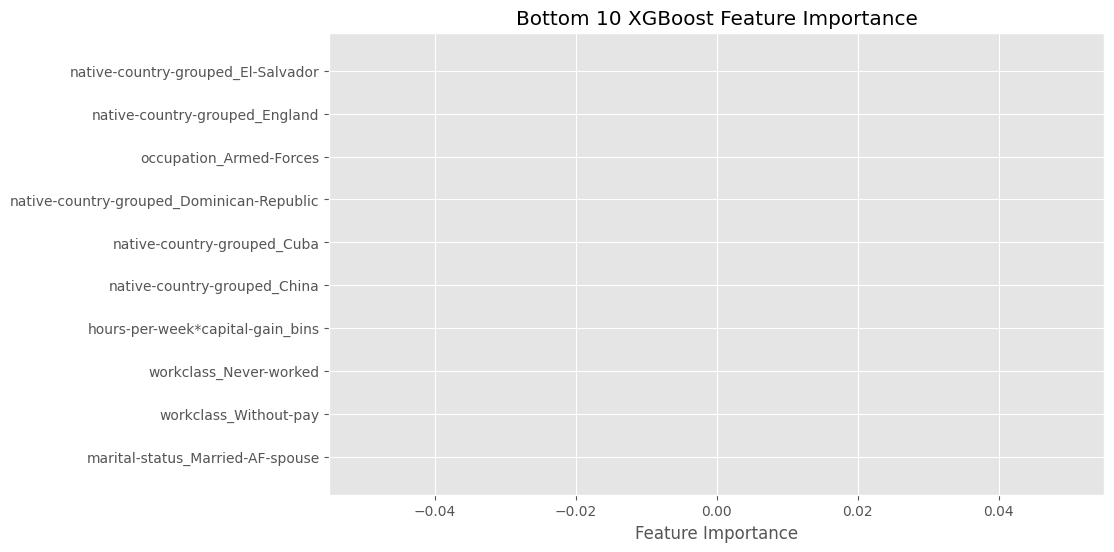

In [ ]:
# Get the bottom 10 least important features for XGBoost
bottom_10_xgb_features = xgb_feature_importance_df.tail(10)

# Plot the bottom 10 feature importance for XGBoost
plt.figure(figsize=(10, 6))
plt.barh(bottom_10_xgb_features['Feature'], bottom_10_xgb_features['Importance'])
plt.title('Bottom 10 XGBoost Feature Importance')
plt.gca().invert_yaxis()  # To show the least important features at the top
plt.xlabel('Feature Importance')
plt.show()

## RadomForestClassifier Model

In [ ]:
'''
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Define scoring method
scorer = make_scorer(accuracy_score)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model,
                              param_grid=param_grid_rf,
                              scoring=scorer,
                              cv=5,  # Number of folds in cross-validation
                              verbose=1,  # Print progress
                              n_jobs=-1)  # Use all available cores

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best Score for Random Forest: ", grid_search_rf.best_score_)

# Predict and evaluate on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
print("Test Accuracy for Random Forest: ", accuracy_score(y_test, y_pred_rf))
'''

'\n# Define the Random Forest model\nrf_model = RandomForestClassifier(random_state=42)\n\n# Define the parameter grid\nparam_grid_rf = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 10, 20, 30],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'max_features\': [\'auto\', \'sqrt\'],\n    \'bootstrap\': [True, False]\n}\n\n# Define scoring method\nscorer = make_scorer(accuracy_score)\n\n# Initialize GridSearchCV\ngrid_search_rf = GridSearchCV(estimator=rf_model,\n                              param_grid=param_grid_rf,\n                              scoring=scorer,\n                              cv=5,  # Number of folds in cross-validation\n                              verbose=1,  # Print progress\n                              n_jobs=-1)  # Use all available cores\n\n# Fit GridSearchCV\ngrid_search_rf.fit(X_train, y_train)\n\n# Print the best parameters and best score\nprint("Best Parameters for Random Forest: ", grid_search_rf.b

In [ ]:
# Define the best parameters from Gridsearch
best_params_rf = {
    'bootstrap':True,
    'max_depth':20,
    'max_features':'sqrt',
    'min_samples_leaf':1,
    'min_samples_split':10,
    'n_estimators':300
}

# Initialize the Random Forest classifier with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params_rf, random_state=42)
# Train the model on the entire training set
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model's performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)
confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Print evaluation results
print(f"Test Accuracy for Random Forest: {accuracy_rf}")
print(f"F1 Score for Random Forest: {f1_rf}")
print(f"Classification Report for Random Forest:\n{report_rf}")
print(f"Confusion Matrix for Random Forest:\n{confusion_matrix_rf}")


Test Accuracy for Random Forest: 0.8629632157237426
F1 Score for Random Forest: 0.6790281329923273
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     11169
           1       0.77      0.61      0.68      3484

    accuracy                           0.86     14653
   macro avg       0.83      0.78      0.80     14653
weighted avg       0.86      0.86      0.86     14653

Confusion Matrix for Random Forest:
[[10521   648]
 [ 1360  2124]]


### Random Forest Model Classification Report:

#### Class 0 (<=50K):
- **Precision**: 0.89  
  *89% of individuals predicted as <=50K are correctly classified.*
- **Recall**: 0.94  
  *94% of actual <=50K individuals are correctly classified.*
- **F1-Score**: 0.91  
  *The high F1-Score indicates good precision and recall.*

#### Class 1 (>50K):
- **Precision**: 0.77  
  *77% of individuals predicted as >50K are correctly classified.*
- **Recall**: 0.61  
  *61% of actual >50K individuals are correctly classified.*
- **F1-Score**: 0.68  
  *The lower F1-Score reflects a trade-off between precision and recall due to the class imbalance.*

#### Overall Metrics:
- **Accuracy**: 86.30%  
  *The model correctly classified 86.30% of the total instances.*

#### Class Imbalance:
- **Class Distribution**:
  - Class 0 (<=50K): 37,155 instances
  - Class 1 (>50K): 11,687 instances
  *Class 1 is underrepresented, which contributes to the lower recall and F1-Score for individuals with income >50K.*

#### Confusion Matrix Interpretation


- **True Positives (TP)**: 2124  
  The model correctly predicted 2124 instances of Class 1 (positive class, >50K income).

- **True Negatives (TN)**: 10521  
  The model correctly predicted 10521 instances of Class 0 (negative class, <=50K income).

- **False Positives (FP)**: 648  
  The model incorrectly predicted 648 instances as Class 1 when they were actually Class 0.

- **False Negatives (FN)**: 1360  
  The model incorrectly predicted 1360 instances as Class 0 when they were actually Class 1.

### Performance Insights

- The model performs well in identifying Class 0 (low-income individuals), with relatively few misclassifications (648).
- The model has more difficulty with Class 1 (higher-income individuals), as indicated by a higher number of false negatives (1360), meaning it misses several instances of Class 1.




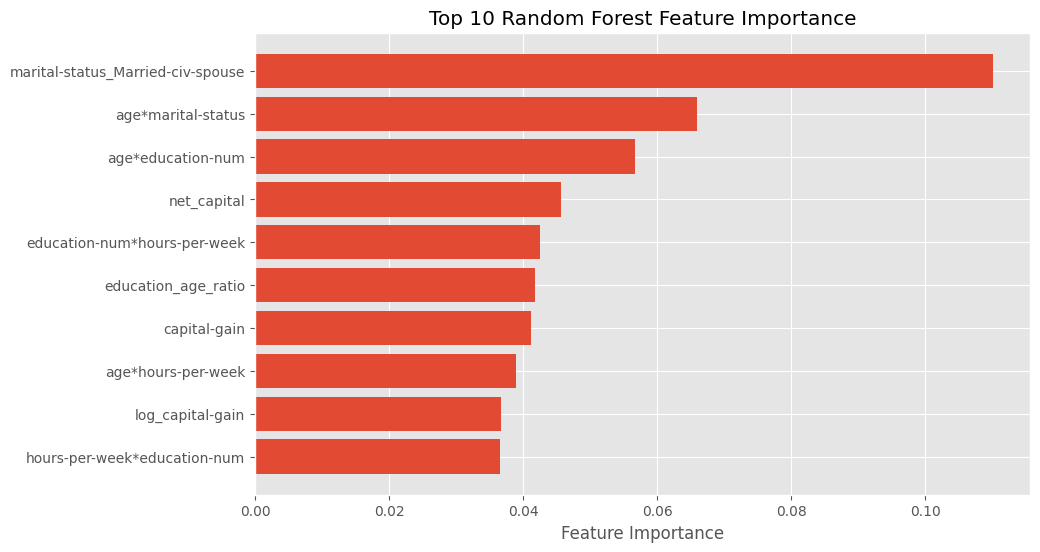

In [ ]:
# Get feature importance from the trained RandomForest model
rf_feature_importances = best_rf_model.feature_importances_

# Create a DataFrame and sort by importance
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_rf_features = rf_feature_importance_df.head(10)

# Plot the top 10 feature importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(top_10_rf_features['Feature'], top_10_rf_features['Importance'])
plt.title('Top 10 Random Forest Feature Importance')
plt.gca().invert_yaxis()  # To show the most important features at the top
plt.xlabel('Feature Importance')
plt.show()

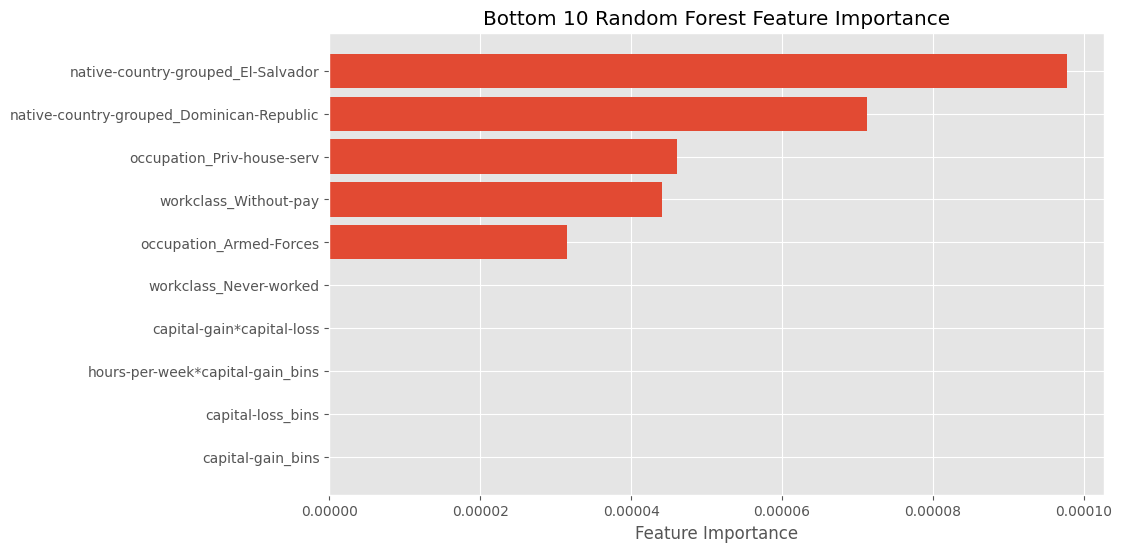

In [ ]:
# Get the bottom 10 least important features for RandomForest
bottom_10_rf_features = rf_feature_importance_df.tail(10)

# Plot the bottom 10 feature importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(bottom_10_rf_features['Feature'], bottom_10_rf_features['Importance'])
plt.title('Bottom 10 Random Forest Feature Importance')
plt.gca().invert_yaxis()  # To show the least important features at the top
plt.xlabel('Feature Importance')
plt.show()

In [ ]:
# Assuming rf_feature_importance_df and xgb_feature_importance_df have the feature importance dataframes
# Get top 10 features for Random Forest and XGBoost
top_10_rf_features = rf_feature_importance_df.sort_values(by="Importance", ascending=False).head(10)['Feature'].values
top_10_xgb_features = xgb_feature_importance_df.sort_values(by="Importance", ascending=False).head(10)['Feature'].values

# Subset the data for only the top 10 features
X_train_rf_top10 = X_train[top_10_rf_features]
X_test_rf_top10 = X_test[top_10_rf_features]

X_train_xgb_top10 = X_train[top_10_xgb_features]
X_test_xgb_top10 = X_test[top_10_xgb_features]

# Re-train the Random Forest model using only top 10 features
rf_model_top10 = RandomForestClassifier(**best_params_rf)  # Use the best parameters found earlier
rf_model_top10.fit(X_train_rf_top10, y_train)

# Make predictions using the Random Forest model
rf_preds_top10 = rf_model_top10.predict(X_test_rf_top10)

# Evaluate Random Forest model
print("Random Forest Model using Top 10 Features:")
print(f"Accuracy: {accuracy_score(y_test, rf_preds_top10)}")
print(f"F1 Score: {f1_score(y_test, rf_preds_top10)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, rf_preds_top10)}")
print(f"Classification Report:\n{classification_report(y_test, rf_preds_top10)}")


# Re-train the XGBoost model using only top 10 features
xgb_model_top10 = XGBClassifier(**best_params_xgb)  # Use the best parameters found earlier
xgb_model_top10.fit(X_train_xgb_top10, y_train)

# Make predictions using the XGBoost model
xgb_preds_top10 = xgb_model_top10.predict(X_test_xgb_top10)

# Evaluate XGBoost model
print("XGBoost Model using Top 10 Features:")
print(f"Accuracy: {accuracy_score(y_test, xgb_preds_top10)}")
print(f"F1 Score: {f1_score(y_test, xgb_preds_top10)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, xgb_preds_top10)}")
print(f"Classification Report:\n{classification_report(y_test, xgb_preds_top10)}")

Random Forest Model using Top 10 Features:
Accuracy: 0.8527946495598171
F1 Score: 0.6592955299320803
Confusion Matrix:
[[10409   760]
 [ 1397  2087]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     11169
           1       0.73      0.60      0.66      3484

    accuracy                           0.85     14653
   macro avg       0.81      0.77      0.78     14653
weighted avg       0.85      0.85      0.85     14653

XGBoost Model using Top 10 Features:
Accuracy: 0.8659660137855729
F1 Score: 0.6880559085133419
Confusion Matrix:
[[10523   646]
 [ 1318  2166]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     11169
           1       0.77      0.62      0.69      3484

    accuracy                           0.87     14653
   macro avg       0.83      0.78      0.80     14653
weighted avg       0.86      0.87      0.86     14653



## ROC Curve Comparison for XGBoost and Random Forest Models


In [ ]:
# Predict probabilities for both models
xgb_probs = best_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)
rf_probs = best_rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for XGBoost
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Compute ROC curve and AUC for Random Forest
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

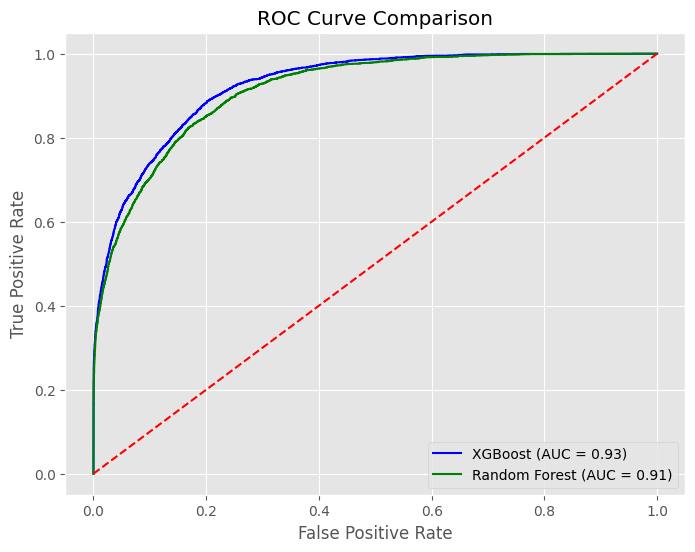

In [ ]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(xgb_fpr, xgb_tpr, color='blue', label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='green', label=f'Random Forest (AUC = {rf_auc:.2f})')

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Customize the plot
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Display the plot
plt.show()

### Model Performance Summary: XGBoost vs Random Forest

#### 1. XGBoost Performance (AUC = 0.93):
- XGBoost demonstrates a high ability to distinguish between positive and negative classes.
- AUC of 0.93 means the model captures 93% of the area under the ROC curve, indicating strong separation of true positives from false positives.
- The curve is closer to the top-left corner, showing a lower False Positive Rate (FPR) and higher True Positive Rate (TPR), meaning fewer false positives while identifying most positive instances correctly.

#### 2. Random Forest Performance (AUC = 0.91):
- Random Forest also performs well, with an AUC of 0.91.
- It captures 91% of the area under the ROC curve, demonstrating good discriminatory power.
- While the difference between XGBoost and Random Forest (AUC 0.93 vs 0.91) is small, XGBoost outperforms Random Forest in classification capability.

#### Key Observations:
- **XGBoost vs. Random Forest**: XGBoost slightly outperforms Random Forest, though both models exhibit strong performance.
- **Difference in AUC**: The difference of 0.02 in AUC might not be statistically significant, but XGBoost generally offers better classification performance.
- **ROC Interpretation**: Both models’ ROC curves lie well above the random guessing line (red dashed diagonal), showing they are effective at separating positive and negative classes.

#### Conclusion:
- **XGBoost** is the better-performing model with a slightly higher AUC and better overall classification capability.
- **Random Forest** remains a strong contender but performs slightly worse in distinguishing between the classes.


# Handling Unbalanced Data

### Handling Unbalanced Data

From both the Random Forest and XGBoost models, it is evident that the models have higher precision and recall for **Class 0** (<=50K). This is due to the unbalanced nature of the dataset:

- **Class 0 (<=50K)** has **37,155** instances
- **Class 1 (>50K)** has **11,687** instances

We can observe that **Class 0** is more than three times the size of **Class 1**, leading to a bias in model performance. To address this imbalance, two common techniques can be applied:

#### 1. **SMOTE (Synthetic Minority Over-sampling Technique)**
   - SMOTE works by generating synthetic samples for the minority class (Class 1). It does so by interpolating between existing minority class instances, thus creating a more balanced dataset for model training.
   - This technique helps in improving the recall for the minority class without simply duplicating existing data points.

#### 2. **RandomUnderSampling**
   - RandomUnderSampling involves reducing the number of instances in the majority class (Class 0) by randomly selecting a subset of data. This balances the dataset by matching the number of instances in both classes.
   - While this helps in reducing the bias towards the majority class, it may result in a loss of information as some majority class instances are discarded.

Both approaches can help improve the model's ability to correctly classify instances of **Class 1** by addressing the imbalance in the dataset.

#### Next Steps:
We will apply **SMOTE** for oversampling and **RandomUnderSampling** to handle the class imbalance, and then retrain the models to observe if this improves the performance on the minority class.


## Oversampling with SMOTE (Synthetic Minority Over-sampling Technique)


In [ ]:
# Apply SMOTE to the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train XGBoost on the balanced data from SMOTE
best_xgb_model.fit(X_train_smote, y_train_smote)

# Make predictions with XGBoost
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Test Accuracy for XGBoost (SMOTE): {accuracy_xgb}")
print(f"F1 Score for XGBoost (SMOTE): {f1_xgb}")
print(f"Classification Report for XGBoost (SMOTE):\n{report_xgb}")

# Train Random Forest on the balanced data from SMOTE
best_rf_model.fit(X_train_smote, y_train_smote)

# Make predictions with Random Forest
y_pred_rf = best_rf_model.predict(X_test)


Test Accuracy for XGBoost (SMOTE): 0.8547055210537091
F1 Score for XGBoost (SMOTE): 0.715564462257849
Classification Report for XGBoost (SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     11169
           1       0.67      0.77      0.72      3484

    accuracy                           0.85     14653
   macro avg       0.80      0.83      0.81     14653
weighted avg       0.86      0.85      0.86     14653



### Model Performance Before and After SMOTE

#### **Before SMOTE:**
- **Test Accuracy for XGBoost**: 0.8719
- **F1 Score for XGBoost**: 0.7108

**Classification Report for XGBoost:**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.90      | 0.94   | 0.92     | 11,169  |
| 1     | 0.77      | 0.66   | 0.71     | 3,484   |

- **Accuracy**: 0.87
- **Macro Avg Precision**: 0.83
- **Macro Avg Recall**: 0.80
- **Macro Avg F1-Score**: 0.81

#### **After SMOTE:**
- **Test Accuracy for XGBoost (SMOTE)**: 0.8547
- **F1 Score for XGBoost (SMOTE)**: 0.7156

**Classification Report for XGBoost (SMOTE):**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.92      | 0.88   | 0.90     | 11,169  |
| 1     | 0.67      | 0.77   | 0.72     | 3,484   |

- **Accuracy**: 0.85
- **Macro Avg Precision**: 0.80
- **Macro Avg Recall**: 0.83
- **Macro Avg F1-Score**: 0.81

#### **Observations:**
- After applying **SMOTE**, the model's ability to classify **Class 1** (the minority class) improved, as evidenced by a higher recall (0.77 vs. 0.66) and a better F1 score (0.72 vs. 0.71).
- The overall **accuracy** decreased slightly (0.8547 after SMOTE vs. 0.8719 before SMOTE), but the **F1 score** for Class 1 improved, indicating better performance for the minority class.
- **Class 0** saw a small drop in precision and recall, which is expected when oversampling is applied, but the overall balance between classes improved.
- The model is now better at identifying positive instances (Class 1), though at the cost of a slight reduction in overall accuracy.

Applying **SMOTE** led to a more balanced performance across both classes, addressing the initial bias toward the majority class.


In [ ]:
# Train Random Forest on the balanced data from SMOTE
best_rf_model.fit(X_train_smote, y_train_smote)

# Make predictions with Random Forest
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Test Accuracy for Random Forest (SMOTE): {accuracy_rf}")
print(f"F1 Score for Random Forest (SMOTE): {f1_rf}")
print(f"Classification Report for Random Forest (SMOTE):\n{report_rf}")

Test Accuracy for Random Forest (SMOTE): 0.8405787210810073
F1 Score for Random Forest (SMOTE): 0.695118767945706
Classification Report for Random Forest (SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     11169
           1       0.64      0.76      0.70      3484

    accuracy                           0.84     14653
   macro avg       0.78      0.81      0.79     14653
weighted avg       0.85      0.84      0.85     14653



### Random Forest Performance Before and After SMOTE

#### **Before SMOTE:**
- **Test Accuracy for Random Forest**: 0.8629
- **F1 Score for Random Forest**: 0.6790

**Classification Report for Random Forest:**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.89      | 0.94   | 0.91     | 11,169  |
| 1     | 0.77      | 0.61   | 0.68     | 3,484   |

- **Accuracy**: 0.86
- **Macro Avg Precision**: 0.83
- **Macro Avg Recall**: 0.78
- **Macro Avg F1-Score**: 0.80

#### **After SMOTE:**
- **Test Accuracy for Random Forest (SMOTE)**: 0.8406
- **F1 Score for Random Forest (SMOTE)**: 0.6951

**Classification Report for Random Forest (SMOTE):**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.92      | 0.86   | 0.89     | 11,169  |
| 1     | 0.64      | 0.76   | 0.70     | 3,484   |

- **Accuracy**: 0.84
- **Macro Avg Precision**: 0.78
- **Macro Avg Recall**: 0.81
- **Macro Avg F1-Score**: 0.79

#### **Observations:**
- After applying **SMOTE**, the model's recall for **Class 1** (the minority class) improved from **0.61** to **0.76**, indicating better performance in identifying instances of the minority class.
- However, the overall **accuracy** dropped slightly (0.84 after SMOTE vs. 0.86 before SMOTE), but this trade-off is acceptable given the improved F1 score and recall for the minority class.
- **Class 0** saw a slight decrease in recall (from 0.94 to 0.86), which is expected after oversampling, as the model now pays more attention to the minority class.
- The overall **F1 score for Class 1** increased from **0.68** to **0.70**, reflecting better balance between precision and recall for the minority class.

In summary, after applying **SMOTE**, the model is better at classifying the minority class (Class 1), improving recall and F1 score for this class, at the cost of a slight decrease in overall accuracy.


## Handling Class Imbalance Using Random Undersampling in XGBoost and Random Forest

In [ ]:
# Apply Random Undersampling to balance the classes
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Train the XGBoost model after undersampling
best_xgb_model.fit(X_train_under, y_train_under)

# Make predictions with XGBoost
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)

print(f"Test Accuracy for XGBoost (Undersampling): {accuracy_xgb}")
print(f"F1 Score for XGBoost (Undersampling): {f1_xgb}")
print(f"Classification Report for XGBoost (Undersampling):\n{report_xgb}")

Test Accuracy for XGBoost (Undersampling): 0.8235173684569713
F1 Score for XGBoost (Undersampling): 0.6979677645409952
Classification Report for XGBoost (Undersampling):
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     11169
           1       0.59      0.86      0.70      3484

    accuracy                           0.82     14653
   macro avg       0.77      0.84      0.79     14653
weighted avg       0.86      0.82      0.83     14653



### XGBoost Performance: Before and After Undersampling

#### **Before Undersampling: XGBoost Performance**

- **Test Accuracy**: 0.8719
- **F1 Score**: 0.7108

**Classification Report for XGBoost (Before Undersampling):**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.90      | 0.94   | 0.92     | 11,169  |
| 1     | 0.77      | 0.66   | 0.71     | 3,484   |

- **Overall Accuracy**: 0.87
- **Macro Avg Precision**: 0.83
- **Macro Avg Recall**: 0.80
- **Macro Avg F1-Score**: 0.81
- **Weighted Avg F1-Score**: 0.87

#### **After Undersampling: XGBoost Performance**

- **Test Accuracy**: 0.8235
- **F1 Score**: 0.6980

**Classification Report for XGBoost (After Undersampling):**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.95      | 0.81   | 0.88     | 11,169  |
| 1     | 0.59      | 0.86   | 0.70     | 3,484   |

- **Overall Accuracy**: 0.82
- **Macro Avg Precision**: 0.77
- **Macro Avg Recall**: 0.84
- **Macro Avg F1-Score**: 0.79
- **Weighted Avg F1-Score**: 0.83

### **Key Observations:**
1. **Before Undersampling**:
   - Class 0 shows strong performance with a precision of 0.90 and recall of 0.94.
   - Class 1, the minority class, struggles with recall (0.66), leading to a lower F1 score of 0.71.
   - Overall accuracy is higher (0.87), with the model favoring Class 0 due to class imbalance.

2. **After Undersampling**:
   - Class 1 recall significantly improves to 0.86, meaning more positive instances are correctly identified after undersampling.
   - However, Class 1 precision drops to 0.59, indicating an increase in false positives.
   - Class 0 precision improves to 0.95, but recall drops to 0.81, showing a trade-off due to undersampling.
   - Overall accuracy decreases to 0.82, reflecting the improved balance between classes, but with a compromise in performance for Class 0.

### **Conclusion**:
- **Before undersampling**, the model performed better for the majority class (Class 0), with higher overall accuracy but poorer performance on Class 1.
- **After undersampling**, Class 1's recall improved substantially, making the model more balanced, but this led to a slight drop in overall accuracy and a decrease in precision for the minority class.
- Depending on the specific use case, one may prioritize higher recall (after undersampling) for Class 1 at the expense of precision and overall accuracy.


In [ ]:
# Train the Random Forest model after undersampling
best_rf_model.fit(X_train_under, y_train_under)

# Make predictions with Random Forest
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print(f"Test Accuracy for Random Forest (Undersampling): {accuracy_rf}")
print(f"F1 Score for Random Forest (Undersampling): {f1_rf}")
print(f"Classification Report for Random Forest (Undersampling):\n{report_rf}")

Test Accuracy for Random Forest (Undersampling): 0.8114379307991537
F1 Score for Random Forest (Undersampling): 0.6830331536078925
Classification Report for Random Forest (Undersampling):
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     11169
           1       0.57      0.85      0.68      3484

    accuracy                           0.81     14653
   macro avg       0.76      0.83      0.77     14653
weighted avg       0.86      0.81      0.82     14653



# Save the Model

Save the best performing model i.e the XGBoost model.

In [ ]:
import joblib

# Save the trained model to a file
model_filename = 'best_xgb_model.joblib'
joblib.dump(best_xgb_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to best_xgb_model.joblib


# Summary and Recommendation

# Exploratory Data Analysis (EDA) Summary

## 1. Class Imbalance
  - There is a significant imbalance in the target variable (`income`).
  - The majority of the data belongs to the class **income <= 50K**, while a smaller portion falls under **income > 50K**.
  - Techniques like **SMOTE**, **undersampling**, or **class weighting** are necessary and were used to improve the performance for the minority class.
  

## 2. Feature Correlations
- **Age, Education, and Hours-per-Week**:
  - Higher education levels, age, and hours worked per week have a positive relationship with higher income.
  - Individuals with advanced education and more working hours tend to fall into the **income > 50K** category.
  
- **Capital-Gain**:
  - A critical feature in determining income. Individuals with significant capital gains are more likely to earn **> 50K**.
  
- **Occupation and Workclass**:
  - Certain professions and work classes (like executive roles and private sector jobs) are more common in the **income > 50K** group.

## 3. Distribution of Categorical Features
- **Occupation and Education**:
  - Highly skilled occupations and higher education levels are more concentrated among individuals earning more than 50K.
  
- **Gender**:
  - There’s a gender disparity, with **males** being over-represented in the **income > 50K** group.

## 4. Missing or Erroneous Data
- Some missing or erroneous entries (like `?` in workclass or occupation) were identified and handled.
- These could be due to people not reporting their work status or classification properly.

## 5. Impact of Age Binning
- Binning the `age` into ranges highlighted the effect of age on income, with older age groups (40-60) having a higher likelihood of earning **> 50K**.

## 6. Capital Gains and Losses
- **Capital Gains**: Show a strong positive impact on higher income.
- **Capital Losses**: Have no clear relationship with income but may have a slight influence in certain cases.

## 7. Effect of Hours Worked per Week
- Individuals working more hours per week tend to fall into the higher income bracket.
- However, diminishing returns were observed after a certain number of hours.

## 8. Feature Importance
- From XGBoost modeling:
  - The top 10 performing features are: `marital-status_Married-civ-spouse`, `age*marital-status`, `age*education-num`, `net-capital`, `education-num*hours-per-week`, `education_age_ratio`, `capital-gain`, `age*hours-per-week`, `log_capital-gain`, `hours-per-week*education-num`.


# Recommendations

## 1. Address Class Imbalance
- **Issue**: The dataset has a significant class imbalance, with far fewer examples of individuals earning more than 50K compared to those earning less.
  - **Recommendation**: To improve model performance on the minority class, apply techniques such as:
    - Adding more data for the underrepresented class (individuals earning above 50k) would help increasing learning for the minority class.
    - **SMOTE (Synthetic Minority Over-sampling Technique)**: To generate synthetic examples of the minority class.
    - **Undersampling**: Reduce the number of examples in the majority class to balance the dataset.
    - **Class Weighting**: Assign higher weights to the minority class during training to prevent the model from being biased toward the majority class.
  

## 2. Feature Engineering and Selection
- **Issue**: Some features, such as `capital-gain`, `education level`, and `age`, have been identified as highly important, while others have less predictive power.
  - **Recommendation**: Focus on the most impactful features and consider the following:
    - **Create Interaction Features**: Combine features like `age`, `education-num`, and `hours-per-week` to capture interactions that might affect income prediction.
    - **Binning**: Apply binning for features like `age` and `capital-gain` to improve interpretability.
    - **Polynomial Features**: Experiment with polynomial transformations of features like `hours-per-week` or `age` to capture non-linear relationships.

## 3. Handle Multicollinearity
- **Issue**: There is some correlation between continuous variables (e.g., `capital-gain` and `hours-per-week`), which could lead to multicollinearity issues in certain models.
  - **Recommendation**: Address multicollinearity by:
    - Applying **PCA (Principal Component Analysis)** to reduce dimensionality while retaining the essential variance in the data.
    - Using **regularization techniques** like **Lasso** or **Ridge regression** to penalize correlated features.
  
## 4. Normalize Continuous Variables
- **Issue**: The range of continuous features like `capital-gain`, `capital-loss`, and `hours-per-week` is wide, which could negatively impact certain models (e.g., distance-based models).
  - **Recommendation**: Normalize or standardize continuous features to bring all values into a common scale, which will benefit models like logistic regression, k-NN, and neural networks.

## 5. Model Selection and Tuning
- **Issue**: Preliminary analysis indicates that **Random Forest** and **XGBoost** are effective at handling the dataset.
  - **Recommendation**:
    - Use **Optuna** or **GridSearchCV** to perform hyperparameter tuning for both models.
    - Combine **Random Forest** and **XGBoost** in an ensemble model to leverage the strengths of both algorithms.
    - Experiment with **stacking** or **blending** methods to improve model performance.
  
## 6. Improve Minority Class Performance
- **Issue**: The model struggles with predicting the minority class (income > 50K).
  - **Recommendation**: Focus on improving recall for the minority class:
    - Apply **threshold tuning** to increase recall.
    - Use **cost-sensitive learning** techniques by assigning higher penalties to misclassifications of the minority class.
  


## 7. Test with Different Algorithms
- **Issue**: While Random Forest and XGBoost have shown good results, other algorithms may perform better.
  - **Recommendation**: Test additional algorithms like **LightGBM**, **CatBoost**, or **Logistic Regression with Regularization**.